# Day Ahead (N2EX) Price Forecasting Project
This goal of this project is to investigate different models to predict day-ahead N2EX electricity prices. Predictions will be for the price of electricity at 10am for each day. I will create and explore different feature matrices and use different approaches to elaborate the predictions.

### Imports

In [98]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn import metrics 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1st Cycle of Data Science Life Cycle
In this first cycle I will focus only on the dataset containing electricity prices and date. I will first investigate the existing literature about time series forecasting with special attention on feature engineering and ML methods. 

Only one .csv file is needed for this step, so the data collection phase is very short. In order to prepare the data for the model I need to: clean data, check for missing values or errors, convert dataframe elements into correct format, and add all the necessary futures of this cycle. From this dataset I will extract some features such as day of week, month, lagging features and moving averages. After (or during) this, I will conduct an explanatory data analysis and look for correlations, trends and seasonality, as well as check for stationary properties. 

Since this is the first cyle, I will need to model the benchmark model that I aim to beat: predicting electricity prices to be the previos day price. Then, I will try ARIMA and ML models (Random Forest for stationary and non-stationary series) with some parameter selection. Lastly, after creating and fitting the models, I will evaluate them by looking at their different scores and plotting predictions against actual values.

### Business Understanding
There are several different approaches to time series forecasting. Tradicional time series autoregressive approaches such as ARIMA or SARIMA, deep learning algorithms, or other ML approaches like Random Forests. The main advantage of choosing a ML approach is that exogenous factors can be taken into account, whereas using ARIMA only the prices time series are studied. Following this, I have decided to focus on exploring ML models. To do this, I need to include extra features to the feature matrix so that the factors that influence price are captured.

After some research, here is a summary of the main possible features to add to a energy price forecasting model:
***
* Own data feature engineering (first cycle):
    * Date-related features such as day, day of week, day of year, month, year, weekday/weekend and so on...
    * Lag features
    * Moving average features (standard or expanding)
    
***
* Exogenous factors (second and further cycles):
    * Generation data (biomass, fossil fuels, wind, solar)
    * Load data (forecast or actual)
    * Weather data (temp, wind_speed, rain, humidity, preassure, clouds, snow)
    * Other prices data (fuel price, other market price, 
    
Some references:
<br>
Article about feature engineering techniques for time series data <a href='https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/' target="_blank">here</a>
<br>
Article about multivariate time series forecasting using random forests <a href="https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1" target="_blank">here</a>. 
<br>
Kaggle notebook about electricity price forecasting with DNNs <a href="https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda" target="_blank">here</a>.
<br>
Kaggle notebook about time Series - Exploratory Data Analysis & Forecast <a href="https://www.kaggle.com/rgrajan/time-series-exploratory-data-analysis-forecast" target="_blank">here</a>.
<br>
Article about 'Statistical Modeling of Time Series Data Part 2: Exploratory Data Analysis' <a href="https://towardsai.net/p/data-visualization/statistical-modeling-of-time-series-data-part-2-exploratory-data-analysis" target="_blank">here</a>.
<br>
Article about 'How-To Guide on Exploratory Data Analysis for Time Series Data' <a href="https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f" target="_blank">here</a>


### Data Collection
Since the first cycle is just with the original market price data, we do not need to collect any more datasets and so we upload the following .csv:

In [99]:
# Upload main dataset for hourly market prices from June 2020 to June 2021
data = pd.read_csv('Data/n2ex_prices.csv')

In [100]:
# Adding missing date 
data = data.append({'value': 46.28, 'date': '2020-08-14', 'start_time_uk': '10:00:00'}, ignore_index=True)

In [101]:
# Making sure that it was appended
data.loc[data.date == '2020-08-14']

value        date start_time_uk
8616  46.28  2020-08-14      10:00:00

### Data Preparation

In [102]:
# Convert to datetime
data['date'] = pd.to_datetime(data.date, format="%Y-%m-%d")
data['start_time_uk'] = pd.to_datetime(data.start_time_uk, 
                                       format='%H:%M:%S').dt.time

In [103]:
# Filter to only include 10am prices
data = data.loc[data.start_time_uk == dt.time(10, 0)]

In [104]:
# Sort by date 
data.sort_values(by=['date'], ignore_index=True, 
                 inplace=True)

In [105]:
# Save to a csv file to use in future codes
data.to_csv('Data/price_data.csv', index=False)

In [106]:
# Make 'date' the index
data.index = data['date'].rename('index')
data.index = pd.to_datetime(data.index)

In [107]:
# Checking for missing dates, if any found, return to 'Data Collection' to add it
pd.date_range(start = '2020-06-30', end = '2021-06-24' ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [108]:
# Create new columns with day of week ,year and month and weekday/weekend.
def add_day_week(dataframe):
    dataframe['weekday'] = dataframe['date'].apply(lambda x: x.weekday())
    
def add_month(dataframe):
    dataframe['month'] = dataframe['date'].apply(lambda x: x.month)
    
def add_year(dataframe):
    dataframe['year'] = dataframe['date'].apply(lambda x: x.year)
    
def add_day_week_name(dataframe):
    dataframe['weekday_name'] = dataframe['date'].apply(lambda x: x.strftime('%A'))

def add_month_name(dataframe):
    dataframe['month_name'] = dataframe['date'].apply(lambda x: x.strftime('%B'))
    
def weekday_weekend(dataframe):
    dataframe['weekday_or_weekend'] = dataframe['date']\
    .apply(lambda x: 1 if x.strftime('%A') in ('Saturday','Sunday') else 0) #Split sunday and saturday
    
def add_day_month(dataframe):
    dataframe['day_month'] = dataframe['date'].apply(lambda x: x.day)

In [109]:
add_day_week(data)
add_month(data)
add_year(data)
add_day_week_name(data)
add_month_name(data)
weekday_weekend(data)
add_day_month(data)

In [110]:
# Drop date column
data.drop(labels='date', axis=1, inplace=True)

In [111]:
data.info()
print("Dataframe shape: ", data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2020-06-30 to 2021-06-24
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               360 non-null    float64
 1   start_time_uk       360 non-null    object 
 2   weekday             360 non-null    int64  
 3   month               360 non-null    int64  
 4   year                360 non-null    int64  
 5   weekday_name        360 non-null    object 
 6   month_name          360 non-null    object 
 7   weekday_or_weekend  360 non-null    int64  
 8   day_month           360 non-null    int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 28.1+ KB
Dataframe shape:  (360, 9)


In [112]:
# Print NaNs and duplicates in a dataframe
def NaN_duplicates(dataframe):
    print('There are {} missing values or NaNs in data.'
          .format(dataframe.isnull().values.sum()))

    duplicates_num = dataframe.duplicated(keep='first').sum()
    print('There are {} duplicate rows in data based on all columns.'
          .format(duplicates_num))

In [113]:
NaN_duplicates(data)

There are 0 missing values or NaNs in data.
There are 0 duplicate rows in data based on all columns.


In [114]:
# Build i day lag feature (revise after EDA)
def add_lag_feature(lag_num, column_to_lag, dataframe):
    """
    Adds one column to the data frame with some column's lagged values.
    Parameters:
    - lag_num: this is the number of lags we want, for example we can lag
        a column one day, two, three...
    - column_to_lag: this is the dataframe column we want to lag
    - dataframe: this is the dataframe to which we want to apply the lag function.
    """
    dataframe[str(lag_num) + '_day_lag'] = dataframe[column_to_lag].shift(lag_num).fillna(method='bfill')

In [115]:
for i in range(1,14):
    add_lag_feature(i, 'value', data)

In [116]:
# Add standard moving average columns
def add_standard_moving_average(window, column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's standard moving average.
    Parameters:
    - window: this is the number of rows we average over.
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe[str(window) + '_std_moving_average'] = dataframe[column_to_average].rolling(window, min_periods=1).mean()

In [117]:
# Add expanding moving average 
def add_expanding_moving_average(column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's expanding average.
    Parameters:
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe['ex_moving_average'] = dataframe[column_to_average].expanding().mean()

In [118]:
add_standard_moving_average(15,'1_day_lag',data)
add_standard_moving_average(7,'1_day_lag',data)
add_standard_moving_average(2,'1_day_lag',data)
add_standard_moving_average(3,'1_day_lag',data)
add_expanding_moving_average('1_day_lag',data)

### Exploratory Data Analysis

Before creating the models and predicting, I will explore the data as it is right now and try to gain some insights into the different features and their relation with one another. I will also explore the stationarity of the series and differentiate if necessary to make it stationary.

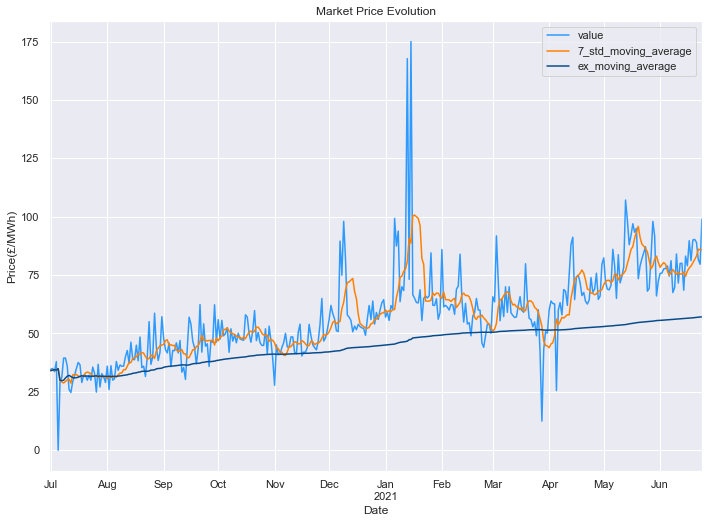

In [119]:
# Basic plot of time series and moving average.
data[['value','7_std_moving_average','ex_moving_average']].plot(
    ylabel='Price(£/MWh)', xlabel='Date', color=['#2E9AFE', '#FF8000','#084B8A'], title='Market Price Evolution')
plt.savefig('Plots/price_evolution.png', bbox_inches='tight')

In this plot we can see a general picture of the evolution of the market price during the year. It is clear how there is an upward trendency and that price overall increase with time. It can also be seen how in January 2021 the price skyrockets during two days, reaching a price of arounf 175, where mos of the previous prices are below 75, so they were most than doubled. 

It can also be seen in red that the seven days moving average captures some of the movements of the price, but many peaks are not included. The two day moving average, on the other hand, matches the peaks better, specially when the variations in price are smaller.

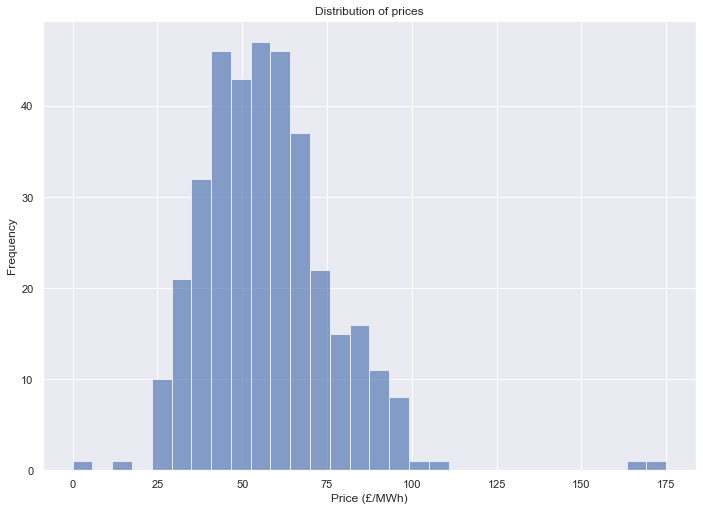

In [120]:
# Plot the histogram of the actual electricity price
ax = data['value'].plot.hist(bins=30, alpha=0.65)
plt.title('Distribution of prices')
plt.xlabel('Price (£/MWh)')
plt.savefig('Plots/prices_dist.png', bbox_inches='tight')

In this histogram we can see how the distribution of the prices resembles a normal distribution positively skewed. We can also see how the very high prices of Januray 2021 are very far from the rest of the values. 

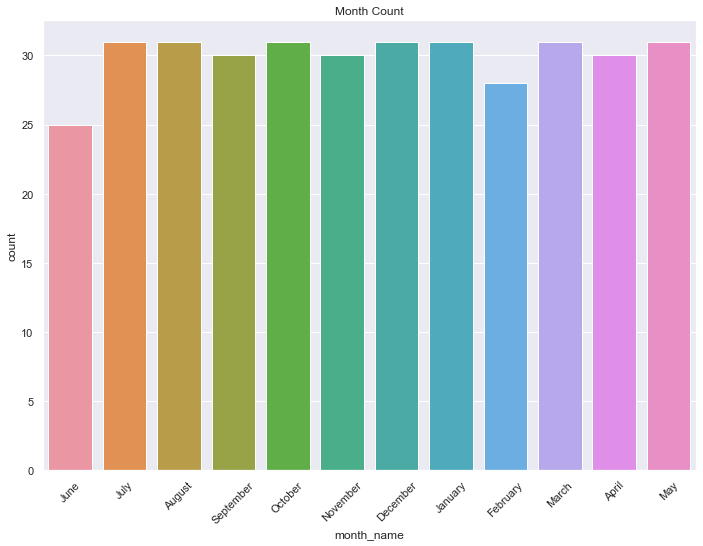

In [121]:
sns.countplot(x=data['month_name'])
plt.title('Month Count')
plt.xticks(rotation=45)
plt.show()

Since we do not have the data for a whole year, it can be seen in this plot how June has less data than any other months. Moreover, June is at the end of the dataframe, so if we split the dates without changing their order, no matter how small we choose the proportion to be, June will always be in the test set.

<AxesSubplot:xlabel='month_name'>

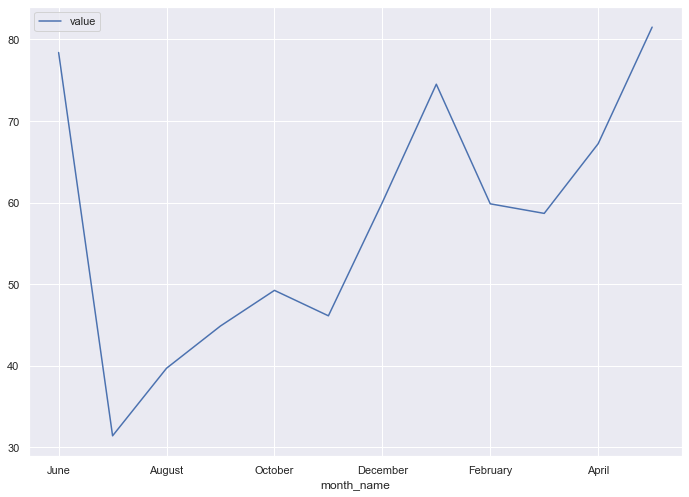

In [122]:
# Groupby month and plot average:
month_df=pd.DataFrame(data.groupby('month_name', sort=False).mean()['value'])
month_df.plot(kind='line')

<AxesSubplot:xlabel='weekday_name'>

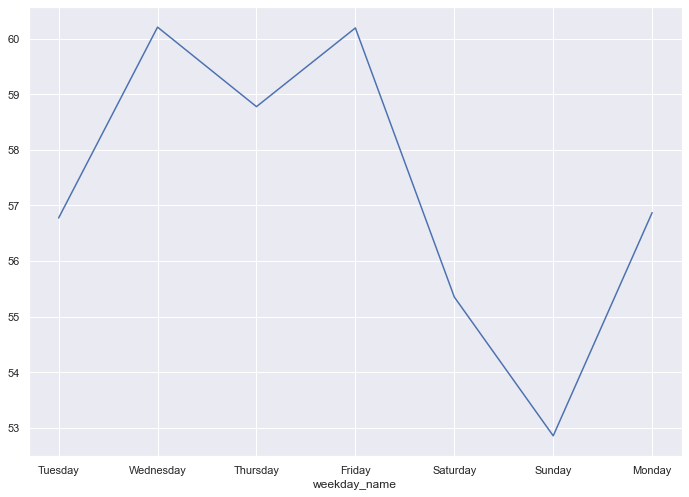

In [123]:
# Group by weekday and plot averages
weekday_df=data.groupby('weekday_name', sort=False).mean()['value']
weekday_df.plot(kind='line')

Here we can see that in general winter months' prices are higher than market prices and how electricity is generally more expensive on weekdays.

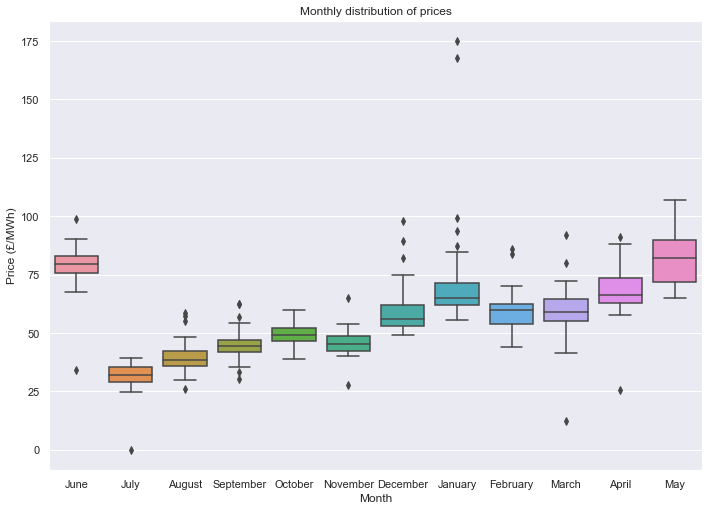

In [124]:
# Monthly price boxplot
sns.boxplot(x="month_name", y="value", data=data)
plt.title('Monthly distribution of prices')
plt.ylabel('Price (£/MWh)')
plt.xlabel('Month')
plt.savefig('Plots/box_month.png', bbox_inches='tight')

We can see how in general the main values of energy prices raise every month, which could mean that the increasing tendency is stronger than the season, and that season is more determinant when analysing outliers.

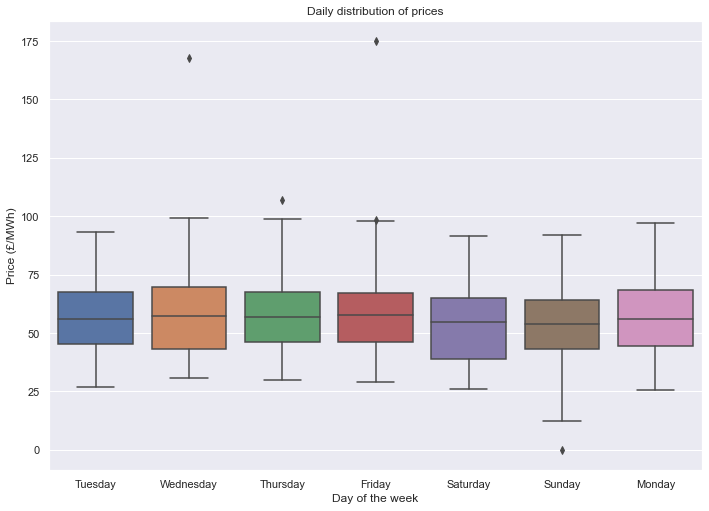

In [125]:
# Weekday price boxplot 
sns.boxplot(x='weekday_name', y='value', data=data)
plt.title('Daily distribution of prices')
plt.ylabel('Price (£/MWh)')
plt.xlabel('Day of the week')
plt.savefig('Plots/box_day.png', bbox_inches='tight')

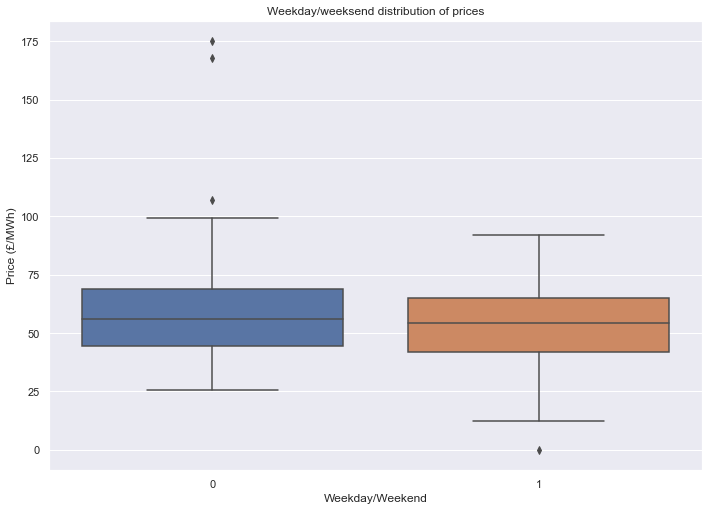

In [126]:
# Weekday price boxplot 
sns.boxplot(x='weekday_or_weekend', y='value', data=data)
plt.title('Weekday/weeksend distribution of prices')
plt.ylabel('Price (£/MWh)')
plt.xlabel('Weekday/Weekend')
plt.savefig('Plots/box_weekend.png', bbox_inches='tight')

Similarly, the distribution over the weeks days doesnt seem to change much, except for the weekend days, which a bit lower. Also, positive outliers happen duting weekdays while negative ones happen on Sunday.

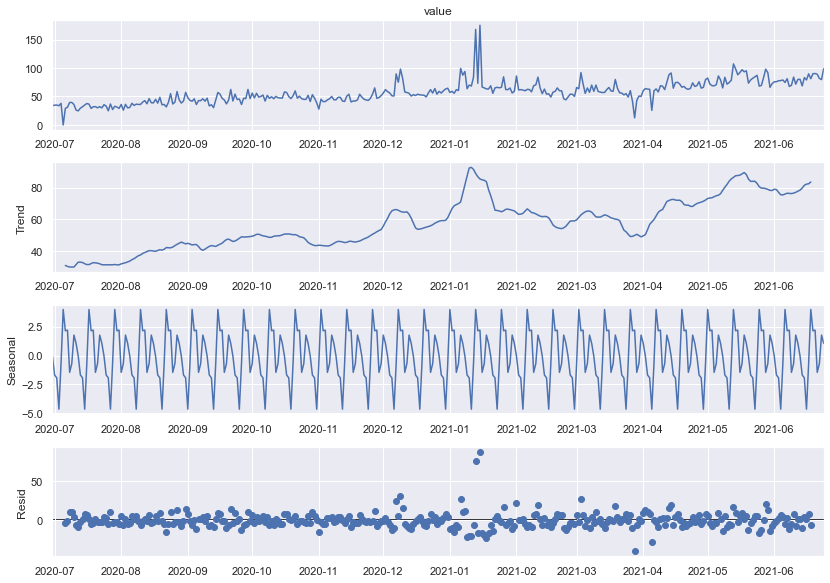

In [127]:
#Graph with trends and seasonality
decomposition = seasonal_decompose(data['value'], period=12)
decomposition.plot()
plt.savefig('Plots/seaso_dec.png', bbox_inches='tight')
plt.show()

We can see here that there is some upward trend on the prices, although it is not so defined as the seasonality.

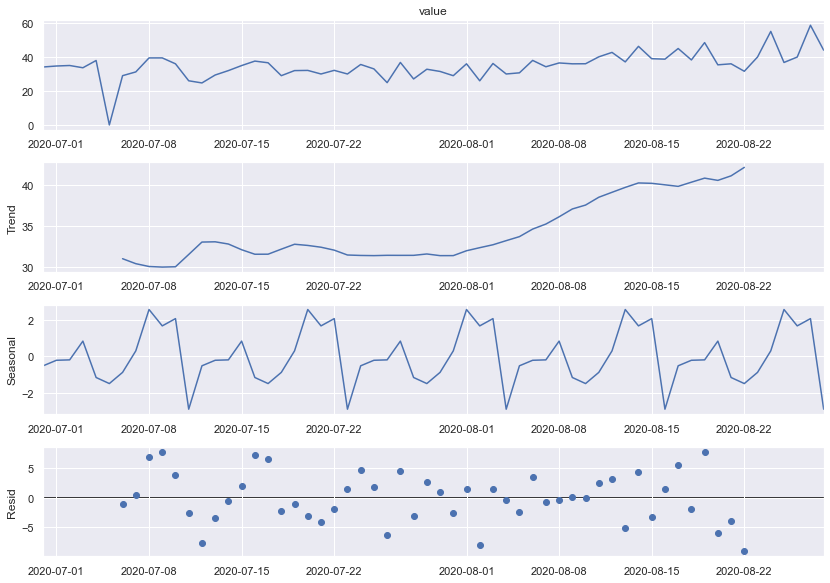

In [128]:
#Graph with trends and seasonality for three months
decomposition = seasonal_decompose(data['value'].head(60), period=12)
decomposition.plot()
plt.show()

If we decompose the series in a smaller period of two months we can have a closer look at its seasonality and see every week and a hald the price drops.

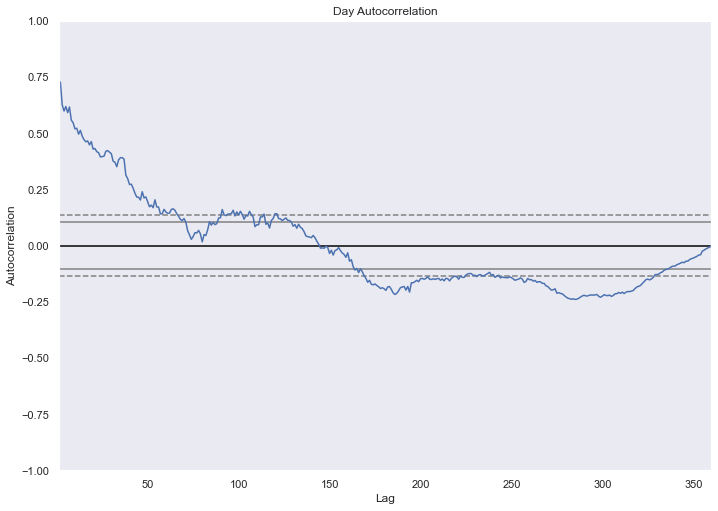

In [129]:
# Autocorrelation plots 
# Autocorrelation with previous days
pd.plotting.autocorrelation_plot(data["value"])
plt.title('Day Autocorrelation')
plt.savefig('Plots/1_day_autoc.png', bbox_inches='tight')

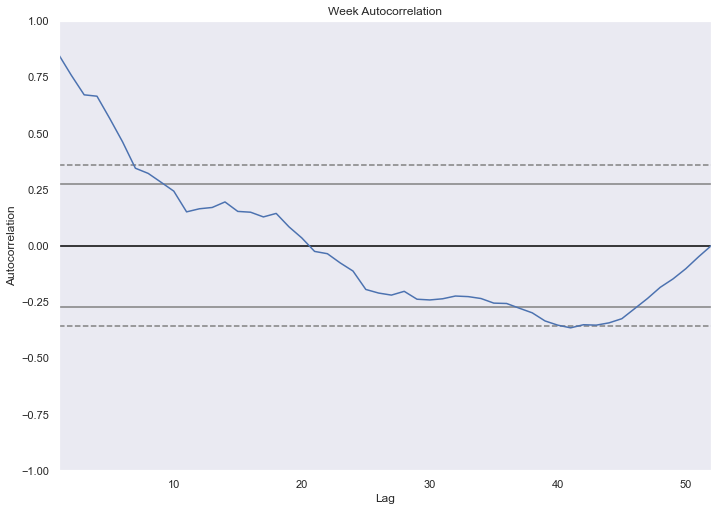

In [130]:
# Autocorrelation with previous weeks
pd.plotting.autocorrelation_plot(data["value"].resample("1w").median())
plt.title('Week Autocorrelation')
plt.savefig('Plots/week_autoc.png', bbox_inches='tight')

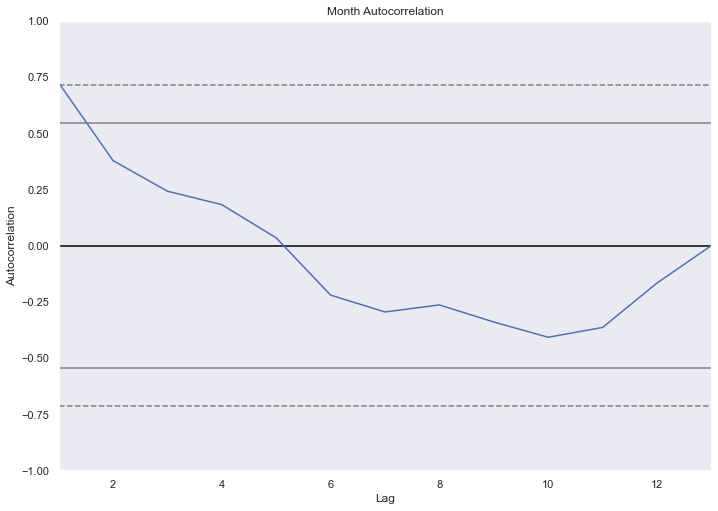

In [131]:
# Autocorrelation with previous months
pd.plotting.autocorrelation_plot(data["value"].resample("1m").median())
plt.title('Month Autocorrelation')
plt.savefig('Plots/month_autoc.png', bbox_inches='tight')

We can see here how the previous 50 days prices have a significant autocorrelation with the electricity price. After this some, periods have anegative autocorrelation, but from this we can decide to focus on the first 20 or so lagged days.

Here we resample the data to weeks, so we can also see how the previous few weeks also have a postive correlation with the present week value.

Lastly, if we resample to months there is not a significant autocorrelation

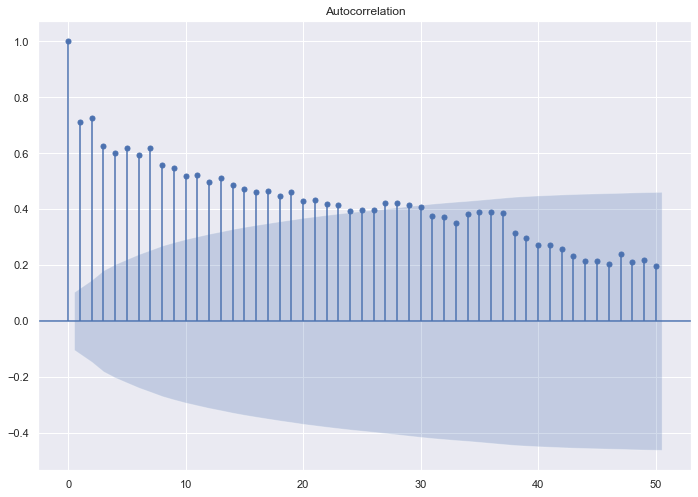

In [132]:
# Plot autocorrelation function
plot_acf(data['value'], lags=50);
plt.savefig('Plots/autoc.png', bbox_inches='tight')

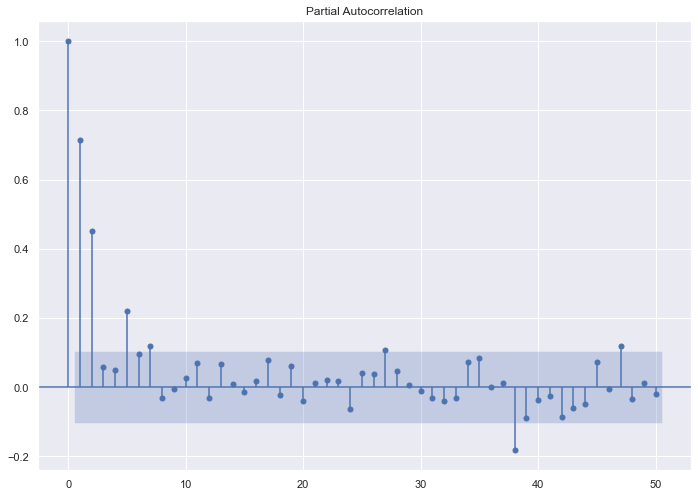

In [133]:
plot_pacf(data['value'], lags=50);
plt.savefig('Plots/partautoc.png', bbox_inches='tight')

Lastly, we plot the autocorrelation and the partial autocorrelation plots, where partial autocorrelation acouts for the correlation between two period ignoring the correlation with the periods inbetween. In the autocorrelation graph we can se how the autocorrelation with previous days decreases, but remains significant until almost thirty days. We can see how the one day and two day lag are correlated with the present market price value, as well as the 5 day lag, but in a lower magnitude. 

In [134]:
# Find correlation between features and price
correlations = data.corr(method='pearson')
print(correlations['value'].sort_values(ascending=False).to_string())

value                    1.000000
2_std_moving_average     0.785488
7_std_moving_average     0.778473
3_std_moving_average     0.773525
15_std_moving_average    0.753963
2_day_lag                0.737897
1_day_lag                0.718286
ex_moving_average        0.717884
7_day_lag                0.657840
year                     0.643790
5_day_lag                0.643352
3_day_lag                0.640728
6_day_lag                0.627235
4_day_lag                0.618285
8_day_lag                0.604600
9_day_lag                0.596019
13_day_lag               0.579868
11_day_lag               0.577927
10_day_lag               0.572215
12_day_lag               0.556936
day_month               -0.044514
weekday                 -0.054765
weekday_or_weekend      -0.103777
month                   -0.396678


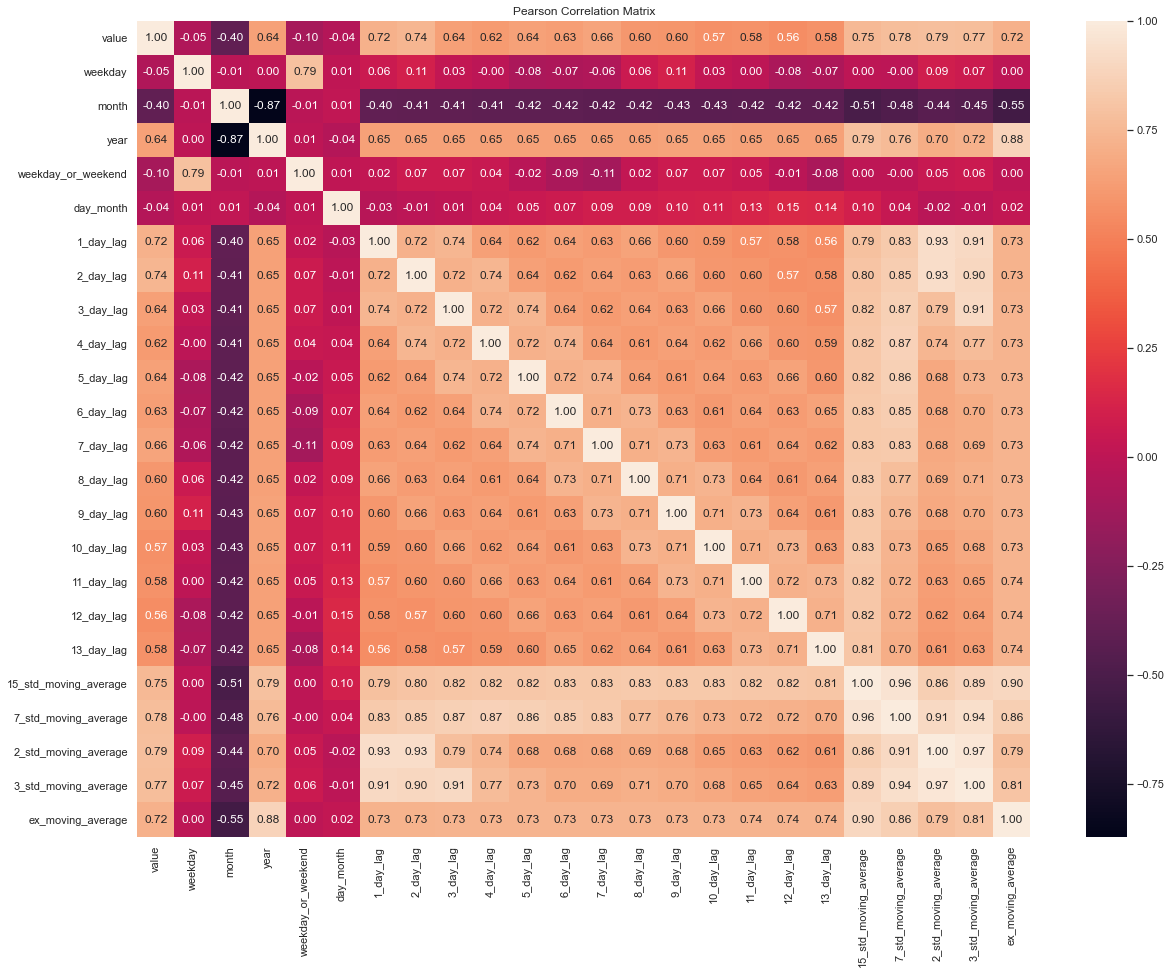

In [135]:
# Plot Pearson correlation matrix
correlations = data.corr(method='pearson')
plt.subplots(figsize=(20,15))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

<AxesSubplot:>

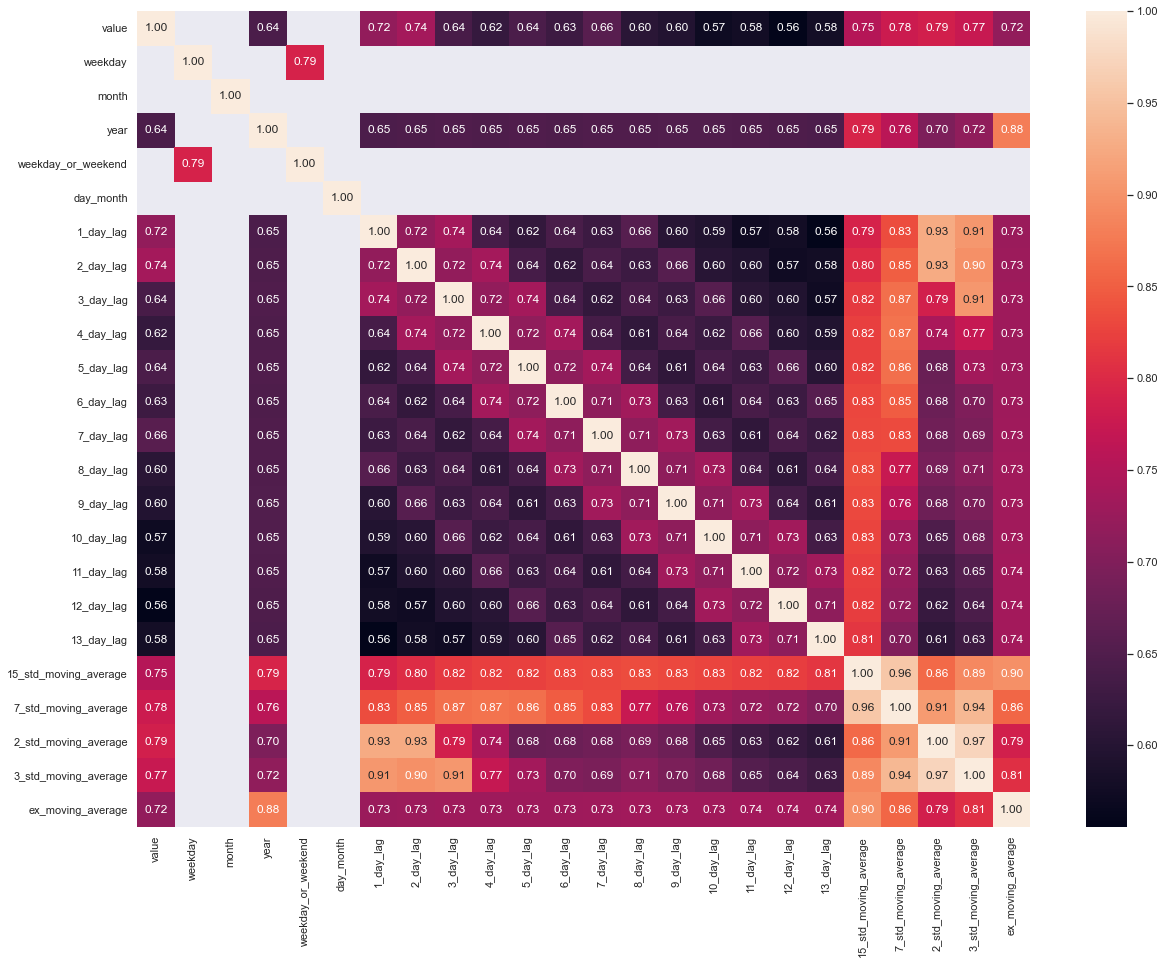

In [136]:
# Print features that are highly correlated to each other
highly_correlated = abs(correlations[correlations > 0.40])
#print(highly_correlated[highly_correlated < 1.0].stack().to_string())
plt.subplots(figsize=(20,15))
sns.heatmap(highly_correlated, annot=True, fmt='.2f')

In [137]:
# Stationarity check with ADF test
dftest = adfuller(data['value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.115916
p-value                          0.238163
#Lags Used                       6.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64


Since the p-value is high, the series is not stationary

In [138]:
# Apply difference transform to make data stationary
data['diff_value'] = data['value'] - data['1_day_lag']

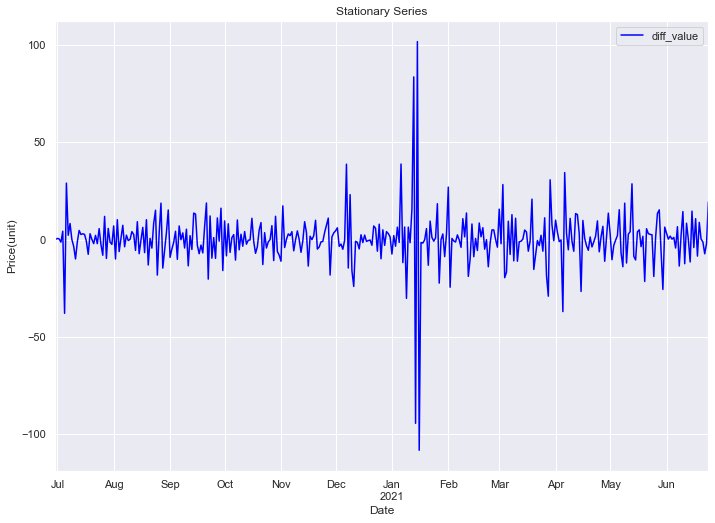

In [139]:
# Basic plot of time series and moving average.
data[['diff_value']].plot(
    ylabel='Price(unit)', xlabel='Date', color=['blue', 'red','green'])

plt.title('Stationary Series')
plt.savefig('Plots/stat_Series.png')

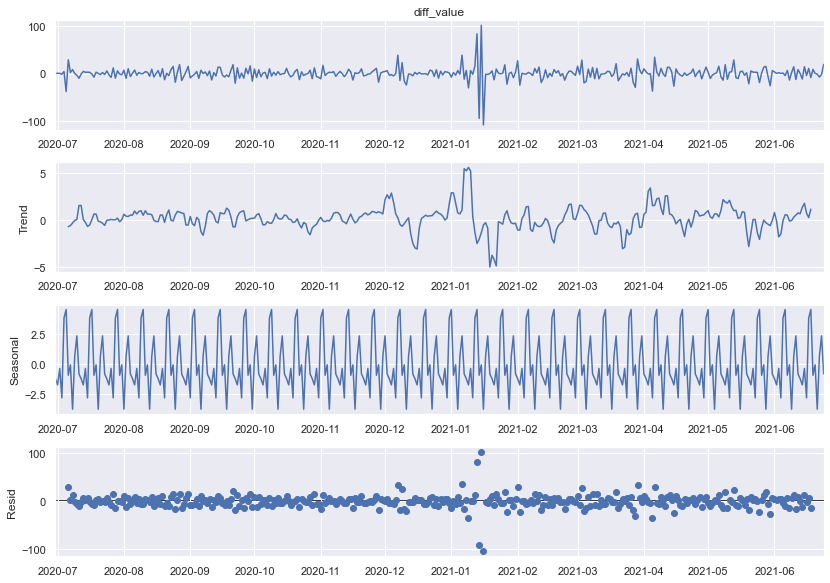

In [140]:
#Graph with trends and seasonality
decomposition = seasonal_decompose(data['diff_value'], period=12)
decomposition.plot()
plt.savefig('Plots/diff_seaso.png', bbox_inches='tight')

Now there is no obvious trend, but some seasonality remains 

In [141]:
# Stationarity check with ADF test
dftest = adfuller(data['diff_value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.289513e+01
p-value                        4.364908e-24
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


Still , the ADF test shows that the series is now stationaty after differentiating

# Modelling

Now that I have explored some the features and gained a much better understanding of the data and the distribution of prices during the year, let us start buiding the different models.

#### Split dates into training and test data

We first need to split the data inti traing and testing data. We will do this by taking the first 80% of the dates as training data and the last 20% as testing data.

In [142]:
# Split into training and test set
def divide_time_df(dataframe, proportion):
    num_dates = dataframe.shape[0]
    head = round(num_dates * proportion, 0)
    tail = num_dates - head 
    print('Total days are {}'.format(data.shape[0]))
    print('Head is {}'.format(head))
    print('Tail is {}'.format(tail))
    return head,tail

In [143]:
head, tail = divide_time_df(data, 0.8)
data_train = data.head(int(head))
data_test = data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

Total days are 360
Head is 288.0
Tail is 72.0


## Benchmark model: Roll forward forecast
In this section I will present the benchmark trivial model that I aim to beat. This model predicts the price for a certain day to be the price of the previous day.

#### Plotting the real values and the predicted ones
First of all, we can quickly plot the actual values and the predicted ones to see the difference between both values over the whole time horizon.

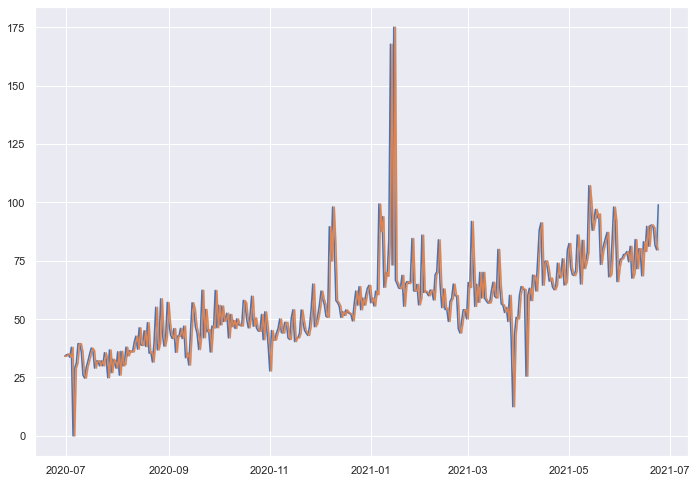

In [144]:
plt.plot(data.index, data.value)
plt.plot(data.index, data['1_day_lag'])
plt.fill_between(data.index, data.value, data['1_day_lag'], color='lightgrey')

We can see how this model would predict well when the prices are gradually decreasing or increasing, since the value for one day would always be closer to the one from previoues days, either approaching from the right or from the left, but it will not predict so well when prices change rapidly from one day to the next one, since then the predicted and the actual prices would differ considerably.

#### Plotting the real values and the predicted ones for the test period only

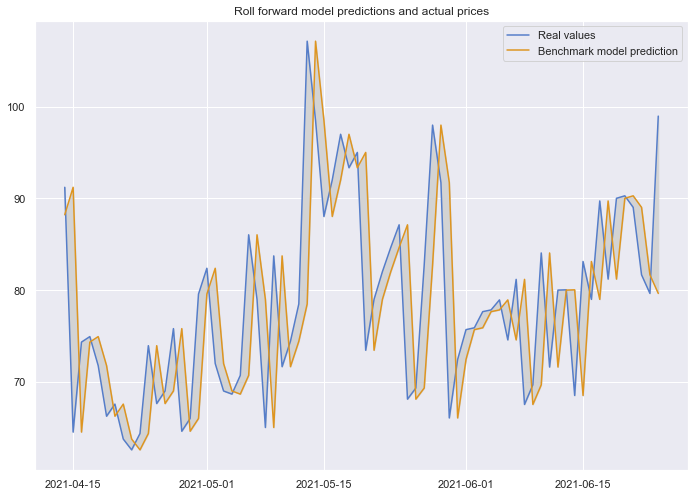

In [145]:
plt.plot(data_test.index, data_test.value, label='Real values', color='#557DC9')
plt.plot(data_test.index, data_test['1_day_lag'], label='Benchmark model prediction', color='#DE9520')
plt.title('Roll forward model predictions and actual prices')
plt.legend()
plt.fill_between(data_test.index, data_test.value, data_test['1_day_lag'], color='lightgrey')
plt.savefig('Plots/roll_line.png', bbox_inches='tight')

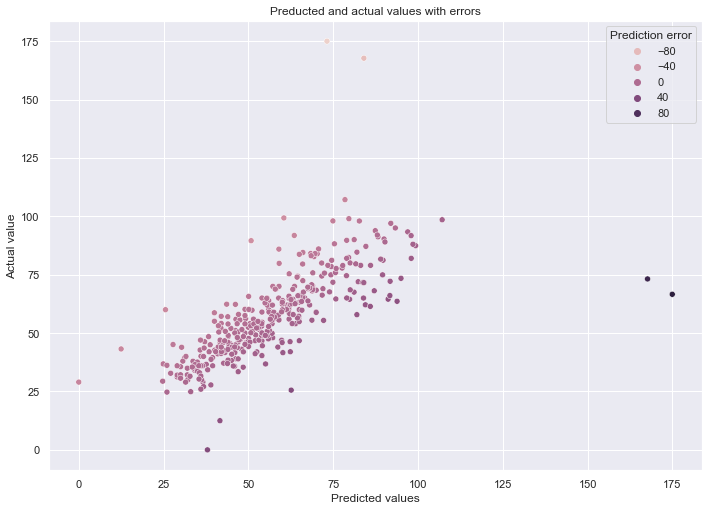

In [146]:
sns.scatterplot(x=data['1_day_lag'], y=data['value'], hue=(data['1_day_lag']-data['value']))
plt.xlabel('Predicted values')
plt.ylabel('Actual value')
plt.legend(title='Prediction error')
plt.title('Preducted and actual values with errors')
plt.savefig('Plots/roll_scatter.png', bbox_inches='tight')

#### Evaluating the roll forward model
We can see from the graph that this model does a generally decent job predicting, but let us now explore the actual scores

In [147]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    This function finds the absolute percentage error of two sets of values
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [148]:
# Scores:
# R^2
print('R2 is {}'.format(metrics.r2_score(data.value,data['1_day_lag'])))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(data.value,data['1_day_lag'])))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(data.value,data['1_day_lag'], squared=False)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(data.value,data['1_day_lag'])))

R2 is 0.4389913229630331
The mean absolute error is 8.268194444444445
The root mean squared error is 14.520602288931865
The mean absolute percentage error is 1068.8204076732832


In [149]:
# Array with all data
X = data['1_day_lag'].values
y = data.value.values

In [44]:
def rolling_expanding_window(n, test_size, X, y, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    mae =[]
    rmse =[]
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        y_hat = X[initial_train:initial_train + test_size]
        y_test = y[initial_train:initial_train + test_size]
        
        score.append(metrics.r2_score(y_test,y_hat))
        
        if plot == True:
            plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            plt.legend()
            plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            plt.savefig('Plots/r_' + str(i) + '.png', bbox_inches='tight')

            plt.show()
            print('R2 are {}'.format(score))
            # MAE
            mae.append(metrics.mean_absolute_error(y_test, y_hat))
            print('The mean absolute error is {}'
                  .format(mae))
            # RMSE
            rmse.append(metrics.mean_squared_error(y_test, y_hat, squared=False))
            print('The root mean squared error is {}'
                  .format(rmse))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score), np.mean(mae), np.mean(rmse))

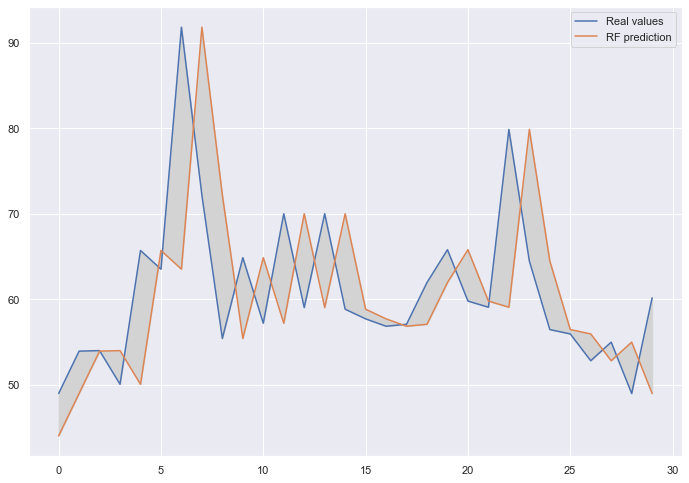

R2 are [-0.4164349387825035]
The mean absolute error is [8.136333333333333]
The root mean squared error is [10.706323520860618]


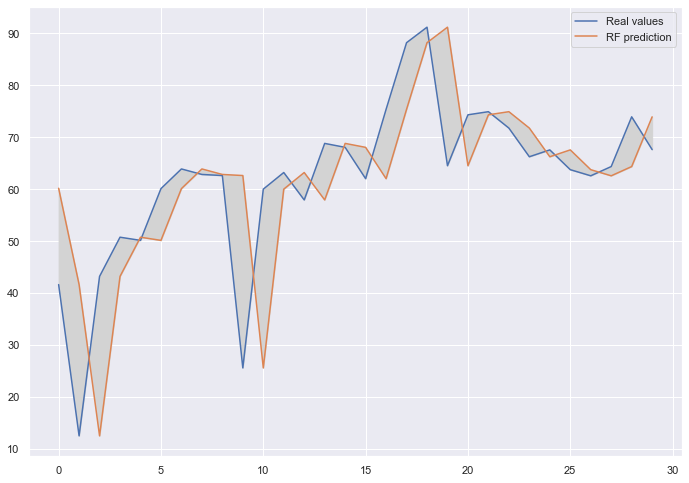

R2 are [-0.4164349387825035, 0.12124117007106205]
The mean absolute error is [8.136333333333333, 9.940333333333335]
The root mean squared error is [10.706323520860618, 14.624970997122238]


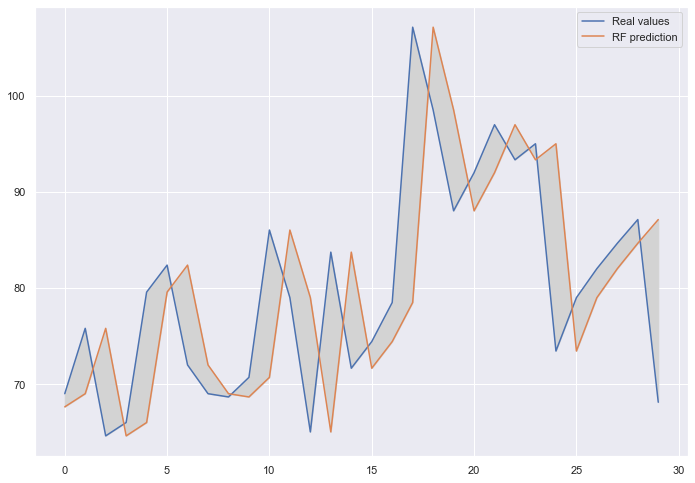

R2 are [-0.4164349387825035, 0.12124117007106205, 0.04676025554229468]
The mean absolute error is [8.136333333333333, 9.940333333333335, 8.105333333333334]
The root mean squared error is [10.706323520860618, 14.624970997122238, 10.692971835119865]


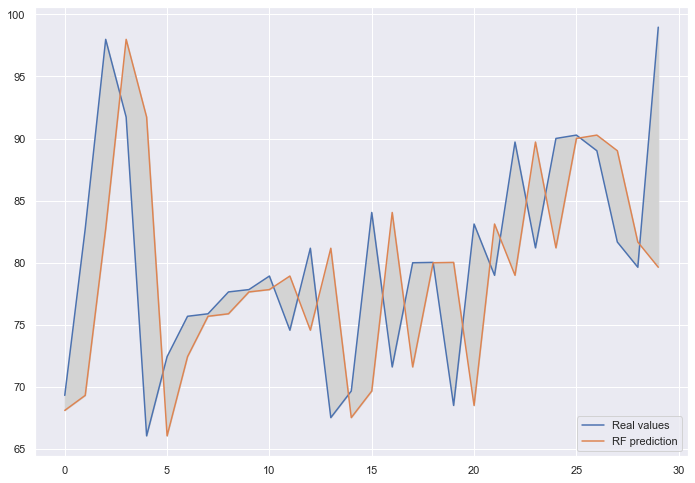

R2 are [-0.4164349387825035, 0.12124117007106205, 0.04676025554229468, -0.3568640187952894]
The mean absolute error is [8.136333333333333, 9.940333333333335, 8.105333333333334, 7.5073333333333325]
The root mean squared error is [10.706323520860618, 14.624970997122238, 10.692971835119865, 9.857427656341182]


(-0.15132438299110904, 8.422333333333334, 11.470423502360974)

In [57]:
rolling_expanding_window(4, 30, X, y, True)

We can see how the R2 value is not too bad (0.43). Root mean square error is 14.5, which is also okay if we keep in mind that prices generally go from 50 to 80. 

### ARIMA model
Let us new try a traditional time series approach (ARIMA). This approach takes the time series, makes it stationary and makes predictions based on the lagged values and the moving averages. We can 

#### Grid search for best ARIMA parameters

In [ ]:
# Grid search
best_score = 0
for p in [0, 1, 2, 5, 7, 30, 50]: 
    for d in range(4):
        for q in range(4):
            print(p,d,q)
            # for each combination of parameters, train an SVC
            model = ARIMA(order=(p,d,q), dates=pd.to_datetime(data_train.index), endog=data_train.value)
            model_fit = model.fit()
            # evaluate the forest on the test set
            prediction = model_fit.predict(start=data_test.index[0], end=data_test.index[-1])
            score = metrics.r2_score(data_test.value,prediction)
            # if we got a better score, store the score and parameters 
            if score > best_score:
                best_score = score
                #best_parameters = {'p': p, 'd': d, 'q': q}
        
print("Best score: {:.2f}".format(best_score)) 
print("Best parameters: {}".format(best_parameters))

#### Fitting the ARIMA model and summary

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  288
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1132.696
Date:                Fri, 02 Jul 2021   AIC                           2273.392
Time:                        13:08:56   BIC                           2288.030
Sample:                    06-30-2020   HQIC                          2279.258
                         - 04-13-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6169      0.222     -2.780      0.005      -1.052      -0.182
ma.L1         -0.1377      0.241     -0.572      0.567      -0.609       0.334
ma.L2         -0.3405      0.170     -2.006      0.0

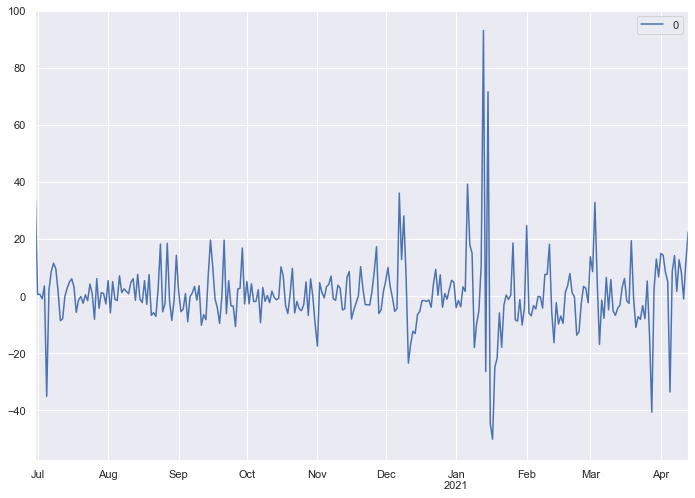

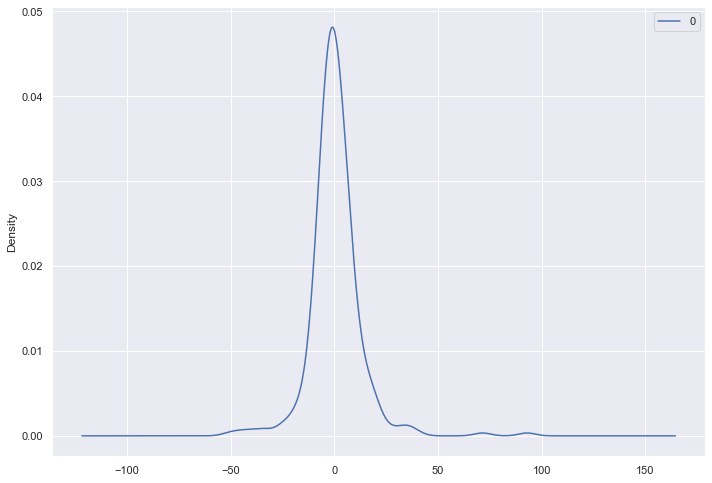

                0
count  288.000000
mean     0.548673
std     12.661230
min    -50.205941
25%     -4.689553
50%     -0.375074
75%      5.125173
max     93.024595


In [45]:
# fit model
model = ARIMA(order=(1,1,2), dates=pd.to_datetime(data_train.index), endog=data_train.value)
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

#### ARIMA model evaluation

In [46]:
prediction = model_fit.predict(start=data_test.index[0], end=data_test.index[-1])

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(data_test.value,prediction)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(data_test.value,prediction)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(data_test.value,prediction)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(data_test.value,prediction)))

R2 is -0.19259464906148538
The mean absolute error is 8.70590469324409
The root mean squared error is 122.85281035007412
The mean absolute percentage error is 10.543560938339752


It looks like the more we approach a straigt horizontal line, the better the model predicts.  could be that these type of models are sensible to parameter selection

#### Plotting real values and predicted ones for ARIMA model

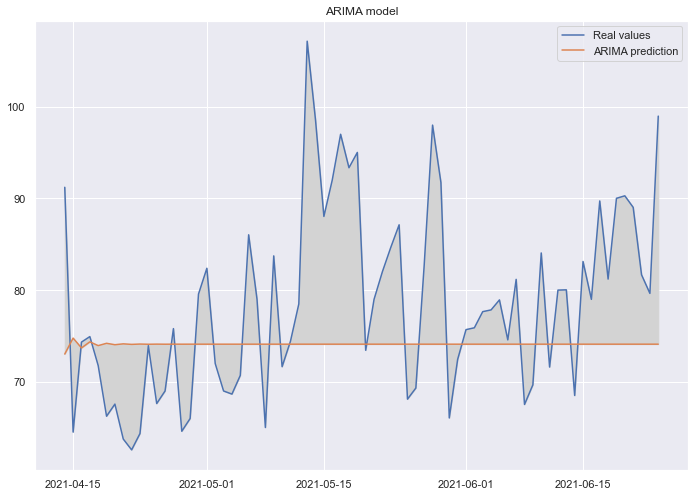

In [48]:
plt.plot(data_test.index, data_test.value, label='Real values')
plt.plot(data_test.index, prediction, label='ARIMA prediction')
plt.legend()
plt.fill_between(data_test.index, data_test.value, prediction, color='lightgrey')
plt.title('ARIMA model')
plt.savefig('Plots/arima_plot.png', bbox_inches='tight')

# Modelling Non-Stationary time series

### Random Forest Model

#### Convert data into training and test arrays

In [51]:
head, tail = divide_time_df(data, 0.8)
data_train = data.head(int(head))
data_test = data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

# Convert to arrays
X_train = data_train.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

Total days are 360
Head is 288.0
Tail is 72.0


#### Grid search for best Random Forest parameters

In [150]:
# Array with all data
X = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name', 'year'], axis=1).values
y = data.value.values

In [151]:
def expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test,y_hat))
        
        if plot == True:
            #plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            #plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            #plt.legend()
            #plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            #plt.show()
            print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [46]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = expanding_window(3, 20, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: -0.18
Best parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}


#### Making and fitting Randon Forest model with chosen parameters

In [152]:
forest = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_split=2, min_samples_leaf=2, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

#### Random Forest Model Evaluation

In [153]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.502
Accuracy on test set: -4.753


We can see how the model gets a very high score for the training set, but very low for the test set. We will see later that this problem becomes very common independtly of the features and parameters used, so maybe random forests are not ideal for this forecast and other methods must be considered.

In [154]:
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

R2 is -4.752564488226656
The mean absolute error is 21.90953030038456
The root mean squared error is 592.5892042655349
The mean absolute percentage error is 26.90080327173255


In [155]:
expanding_window(3, 20, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, True)

NameError: name 'n_estimators' is not defined

#### Plotting predicted and real values of Random Forest

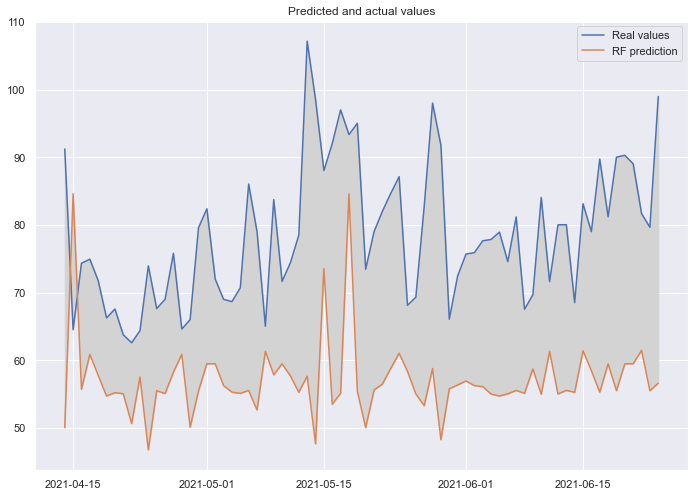

In [156]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
#plt.plot(data_test.index, data_test['1_day_lag'])
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.title('Predicted and actual values')
plt.savefig('Plots/1cycle_rf_plot.png', bbox_inches='tight')

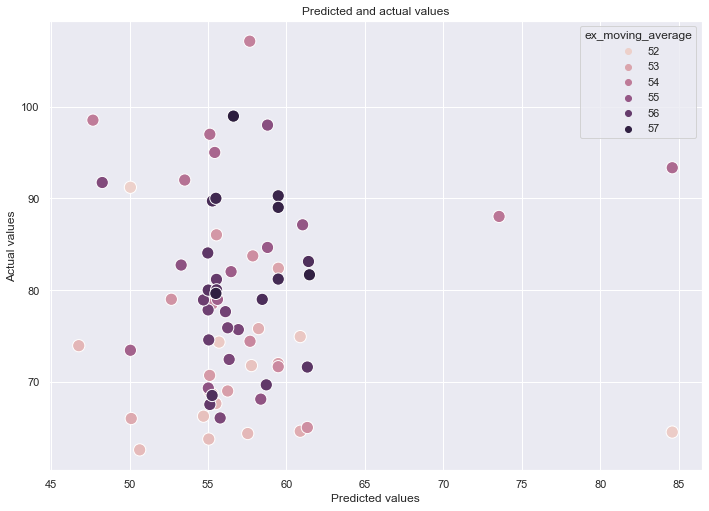

In [157]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values')
plt.savefig('Plots/1cycle_rf_scatter.png', bbox_inches='tight')

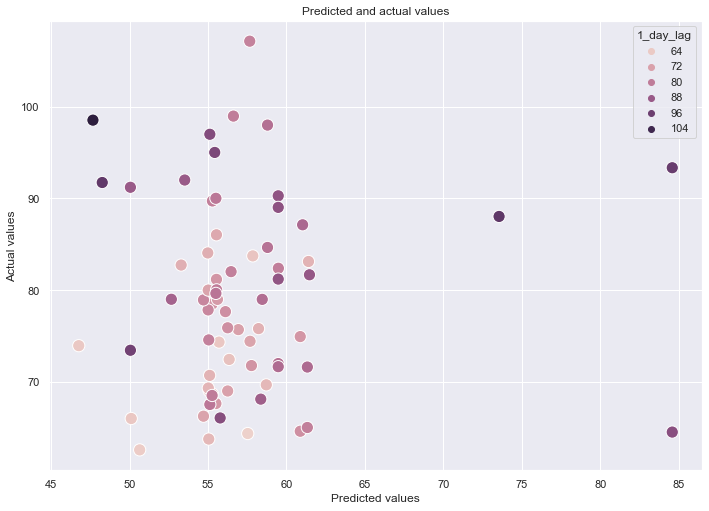

In [158]:
sns.scatterplot(x=y_hat, y=y_test, hue='1_day_lag', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values')
plt.savefig('Plots/1cycle_rf_scatter_lag.png', bbox_inches='tight')

We can see how some of the movements in price are taken and there is some similarities between predictions and actual values, but they are way far from the ones of the rolling forward model.

#### Plotting predicted and real values of the Random Forest with some features

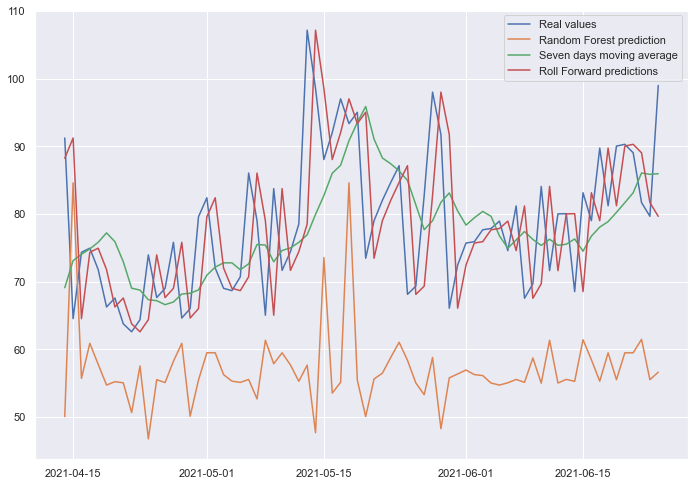

In [159]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Random Forest prediction')
plt.plot(data_test.index, data_test['7_std_moving_average'], 
         label='Seven days moving average')
plt.plot(data_test.index, data_test['1_day_lag'], label='Roll Forward predictions')
plt.legend()

<AxesSubplot:>

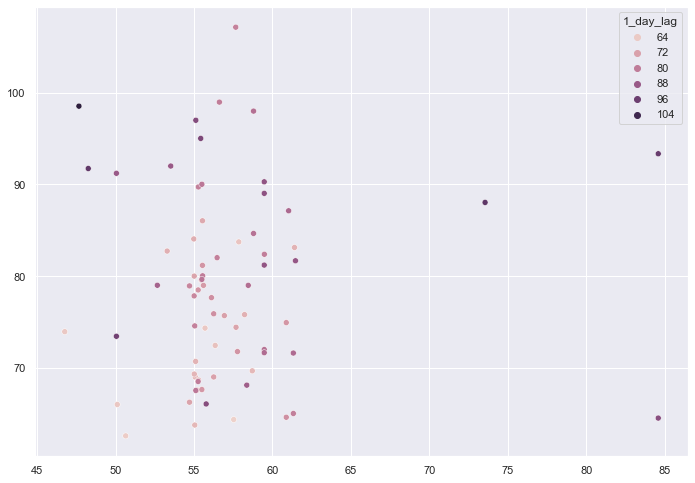

In [160]:
sns.scatterplot(x=y_hat, y=y_test, hue='1_day_lag', data=data_test)

#### Feature importance of the Non-Stationary Random Forest Model

Feature weekday , Score: 1.00000


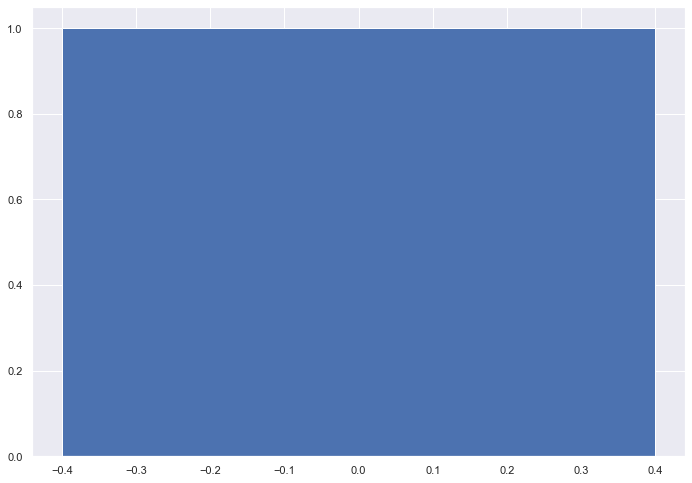

{'weekday': 1.0}
['weekday']


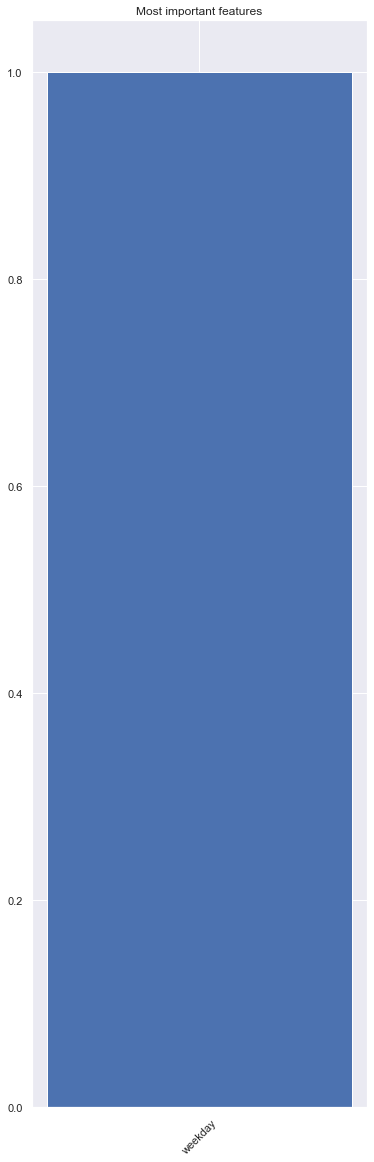

In [161]:
features_names = data.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).columns
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
features_dic={}
for i,v in enumerate(importance):
    print('Feature ' + features_names[i] + ' , Score: %.5f' % (v))
    features_dic[features_names[i]]= v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(features_dic)
five_keys = sorted(features_dic, key=features_dic.get, reverse=True)[:5]
print(five_keys)
most_used = {key: features_dic[key] for key in five_keys}
plt.figure(figsize=(6,20))
plt.bar(most_used.keys(), most_used.values(), width=0.3)
plt.xticks(rotation=45)
plt.title('Most important features')
plt.savefig('Plots/prueba.png', bbox_inches='tight')

## Random Forest with PCA Non-Stationary Time Series

### Creating the PCA Random Forest model Non-Stationary

In [162]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=20, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

expanding_window(3, 20, X_pca, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, False)

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')

Original shape: (360, 23)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.753
Accuracy on test set: -1.340
R2 is -1.3399543081346912
The mean absolute error is 12.688562092947505
The root mean squared error is 241.04582648541574
The mean absolute percentage error is 15.943317049433972


NameError: name 'n_estimators' is not defined

## Lasso Model Non-Stationary Time Series

In [73]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

Accuracy on training set: 0.542
Accuracy on test set: -0.009
R2 is -0.008651760413056042
The mean absolute error is 7.863038054852477
The root mean squared error is 103.90429265199981
The mean absolute percentage error is 9.652953513683121


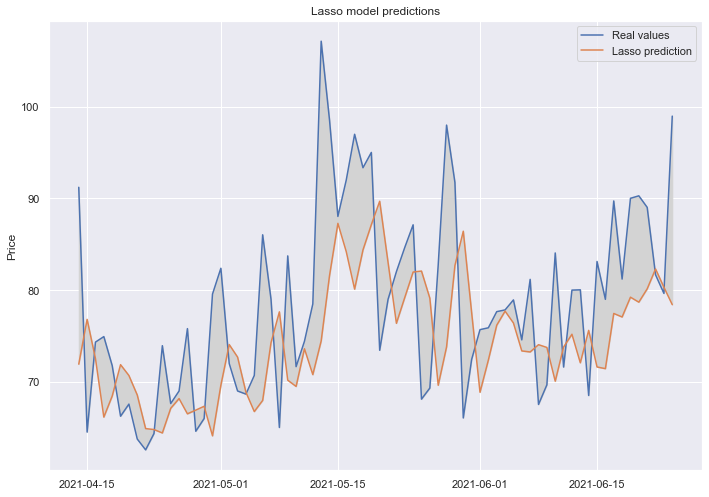

In [74]:
# Create the lasso model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10, max_iter=5000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test, y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test, y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test, y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test, y_hat)))

plt.plot(data_test.index,  y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Lasso prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.title('Lasso model predictions')
plt.ylabel('Price')
plt.savefig('Plots/1cycle_lasso.png', bbox_inches='tight')
plt.show()

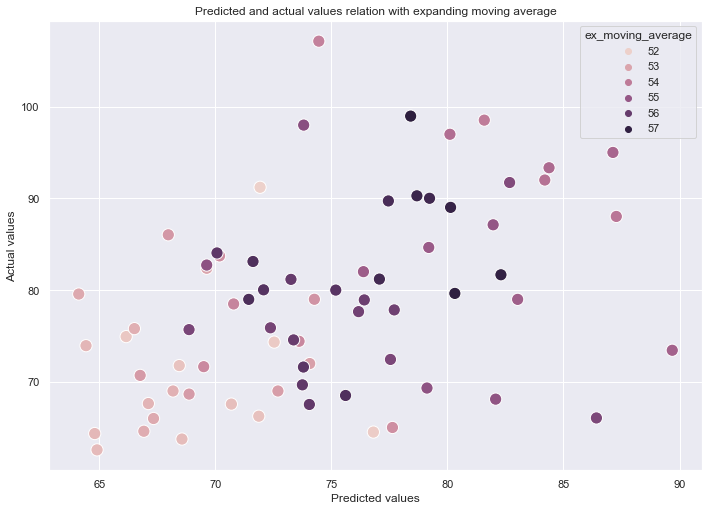

In [68]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/1st_lasso_scatter.png', bbox_inches='tight')

## Elastic Model Non-Stationary Time Series

Accuracy on training set: 0.544
Accuracy on test set: -0.006
R2 is -0.006103205142710122
The mean absolute error is 7.829938089545215
The root mean squared error is 103.64175820449002
The mean absolute percentage error is 9.620710434820538


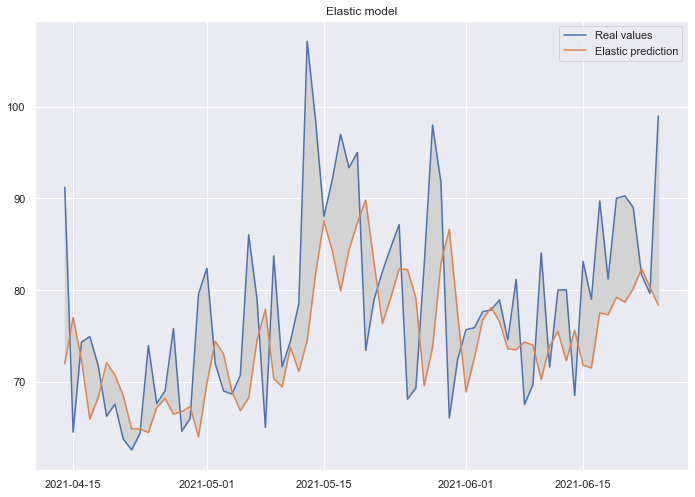

In [72]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=10, l1_ratio=0.9, max_iter=5000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test, y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test, y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test, y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test, y_hat)))

plt.plot(data_test.index,  y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Elastic prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.title('Elastic model')
plt.savefig('Plots/elastic_plot_1.png', bbox_inches='tight')
plt.show()

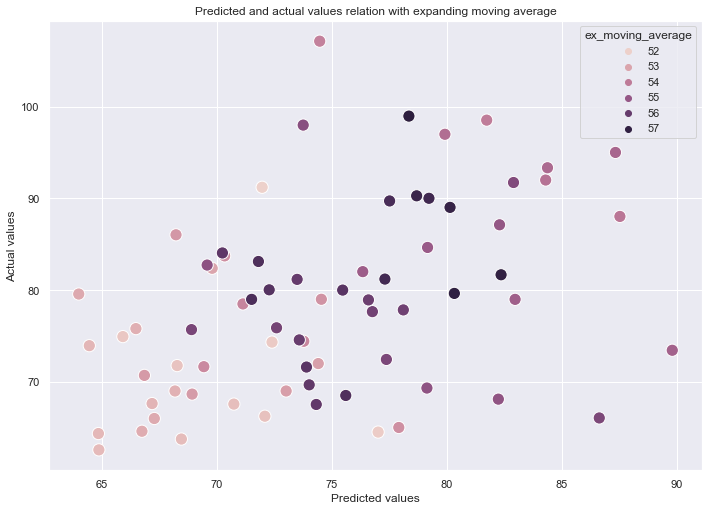

In [71]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/1st_elastc_scatter.png', bbox_inches='tight')

In [59]:
data.head()

value start_time_uk  weekday  month  year weekday_name month_name  \
index                                                                           
2020-06-30  34.12      10:00:00        1      6  2020      Tuesday       June   
2020-07-01  34.70      10:00:00        2      7  2020    Wednesday       July   
2020-07-02  35.00      10:00:00        3      7  2020     Thursday       July   
2020-07-03  33.67      10:00:00        4      7  2020       Friday       July   
2020-07-04  37.94      10:00:00        5      7  2020     Saturday       July   

            weekday_or_weekend  day_month  1_day_lag  ...  10_day_lag  \
index                                                 ...               
2020-06-30                   0         30      34.12  ...       34.12   
2020-07-01                   0          1      34.12  ...       34.12   
2020-07-02                   0          2      34.70  ...       34.12   
2020-07-03                   0          3      35.00  ...       34.12   
2020-07-04                   1          4      33.67  ...       34.12   

            11_day_lag  12_day_lag  13_day_lag  15_std_moving_average  \
index                                                                   
2020-06-30       34.12       34.12       34.12              34.120000   
2020-07-01       34.12       34.12       34.12              34.120000   
2020-07-02       34.12       34.12       34.12              34.313333   
2020-07-03       34.12       34.12       34.12              34.485000   
2020-07-04       34.12       34.12       34.12              34.322000   

            7_std_moving_average  2_std_moving_average  3_std_moving_average  \
index                                                                          
2020-06-30             34.120000                34.120             34.120000   
2020-07-01             34.120000                34.120             34.120000   
2020-07-02             34.313333                34.410             34.313333   
2020-07-03             34.485000                34.850             34.606667   
2020-07-04             34.322000                34.335             34.456667   

            ex_moving_average  diff_value  
index                                      
2020-06-30          34.120000        0.00  
2020-07-01          34.120000        0.58  
2020-07-02          34.313333        0.30  
2020-07-03          34.485000       -1.33  
2020-07-04          34.322000        4.27  

[5 rows x 28 columns]

# Models for the stationary time series (using differentiated values)

Since we saw that the times series was not stationary, we can now try to repeat our Random Forest model, but with the differentiates values and features instead of the original ones

#### New data and new features for stationary time series

In [178]:
# New dataframe with differenciated features and value
diff_data = data.copy()
for i in range(1,14):
    add_lag_feature(i,'diff_value', diff_data)
    
add_standard_moving_average(15,'1_day_lag',diff_data)
add_standard_moving_average(7,'1_day_lag',diff_data)
add_standard_moving_average(3,'1_day_lag',diff_data)
add_standard_moving_average(2,'1_day_lag',diff_data)
add_expanding_moving_average('1_day_lag',diff_data)

In [179]:
data.head()

value start_time_uk  weekday  month  year weekday_name month_name  \
index                                                                           
2020-06-30  34.12      10:00:00        1      6  2020      Tuesday       June   
2020-07-01  34.70      10:00:00        2      7  2020    Wednesday       July   
2020-07-02  35.00      10:00:00        3      7  2020     Thursday       July   
2020-07-03  33.67      10:00:00        4      7  2020       Friday       July   
2020-07-04  37.94      10:00:00        5      7  2020     Saturday       July   

            weekday_or_weekend  day_month  1_day_lag  ...  10_day_lag  \
index                                                 ...               
2020-06-30                   0         30      34.12  ...       34.12   
2020-07-01                   0          1      34.12  ...       34.12   
2020-07-02                   0          2      34.70  ...       34.12   
2020-07-03                   0          3      35.00  ...       34.12   
2020-07-04                   1          4      33.67  ...       34.12   

            11_day_lag  12_day_lag  13_day_lag  15_std_moving_average  \
index                                                                   
2020-06-30       34.12       34.12       34.12              34.120000   
2020-07-01       34.12       34.12       34.12              34.120000   
2020-07-02       34.12       34.12       34.12              34.313333   
2020-07-03       34.12       34.12       34.12              34.485000   
2020-07-04       34.12       34.12       34.12              34.322000   

            7_std_moving_average  2_std_moving_average  3_std_moving_average  \
index                                                                          
2020-06-30             34.120000                34.120             34.120000   
2020-07-01             34.120000                34.120             34.120000   
2020-07-02             34.313333                34.410             34.313333   
2020-07-03             34.485000                34.850             34.606667   
2020-07-04             34.322000                34.335             34.456667   

            ex_moving_average  diff_value  
index                                      
2020-06-30          34.120000        0.00  
2020-07-01          34.120000        0.58  
2020-07-02          34.313333        0.30  
2020-07-03          34.485000       -1.33  
2020-07-04          34.322000        4.27  

[5 rows x 28 columns]

In [180]:
# Dividing the dataframe into test and trining sets.
head, tail = divide_time_df(diff_data, 0.8)
data_train = diff_data.head(int(head))
data_test = diff_data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

# Original data train/test
original_data_train = data.head(int(head))
original_data_test = data.tail(int(tail))

Total days are 360
Head is 288.0
Tail is 72.0


In [181]:
# Converting the dataframes to arrays for sklearn
X_train = data_train.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.diff_value.values
X_test = data_test.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.diff_value.values

#Original data train/test
original_lag = original_data_test['1_day_lag'].values

features_names = diff_data.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).columns

## Solving the Random Forest model for the differentiated values, and adding the originally subtracted lag to see actual predicted values

#### Grid search for best Random Forest parameters

In [166]:
# Array with all data
X = diff_data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1).values
y = diff_data.value.values

In [167]:
def diff_expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        original_lag = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1)['1_day_lag'].values[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test + original_lag,y_hat + original_lag))
                
        if plot == True:
            plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            plt.legend()
            plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            plt.show()
            print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [ ]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = diff_expanding_window(3, 30, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Accuracy on training set: 0.729
Accuracy on test set: 0.157
R2 is 0.16453485217372021
The mean absolute error is 7.382170318524426
The root mean squared error is 86.06381174087167
The mean absolute percentage error is 9.462987721723442


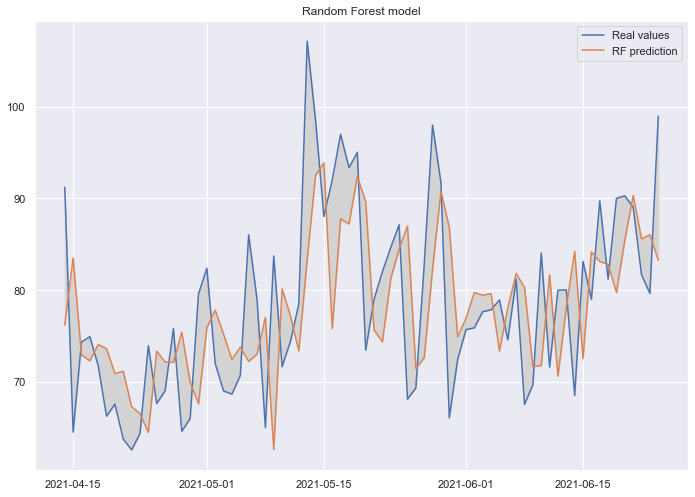

In [168]:
# Create the random forest model
forest = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_split=2, min_samples_leaf=2,  random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

#print(diff_expanding_window(3, 30, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, True))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.title('Random Forest model')
plt.savefig('Plots/1rf_stat_plot.png', bbox_inches='tight')
plt.show()

#### Feature importance of the Differentiated Random Forest Model

Feature weekday , Score: 0.01859
Feature month , Score: 0.00580
Feature year , Score: 0.00026
Feature weekday_or_weekend , Score: 0.00879
Feature day_month , Score: 0.01516
Feature 1_day_lag , Score: 0.24199
Feature 2_day_lag , Score: 0.02296
Feature 3_day_lag , Score: 0.00738
Feature 4_day_lag , Score: 0.02081
Feature 5_day_lag , Score: 0.00781
Feature 6_day_lag , Score: 0.01303
Feature 7_day_lag , Score: 0.06140
Feature 8_day_lag , Score: 0.01028
Feature 9_day_lag , Score: 0.04618
Feature 10_day_lag , Score: 0.00948
Feature 11_day_lag , Score: 0.00876
Feature 12_day_lag , Score: 0.00976
Feature 13_day_lag , Score: 0.01170
Feature 15_std_moving_average , Score: 0.03061
Feature 7_std_moving_average , Score: 0.16148
Feature 2_std_moving_average , Score: 0.01739
Feature 3_std_moving_average , Score: 0.03805
Feature ex_moving_average , Score: 0.23232


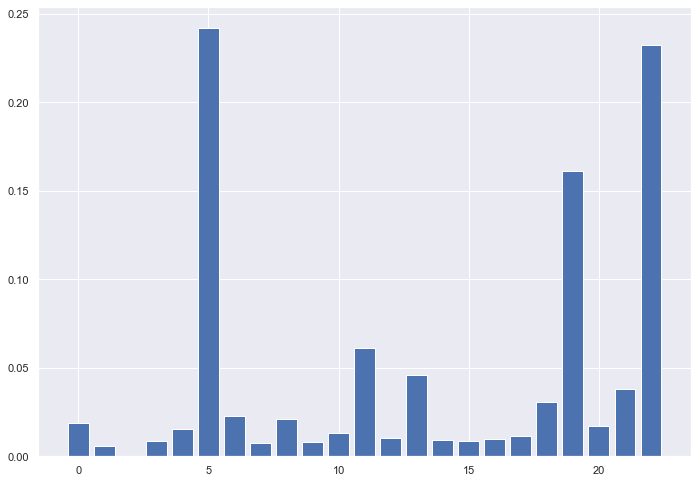

{'weekday': 0.018594837204979002, 'month': 0.005803878125292591, 'year': 0.000256299971434481, 'weekday_or_weekend': 0.008791211276758451, 'day_month': 0.01515613931867973, '1_day_lag': 0.2419903179018883, '2_day_lag': 0.022960798958009957, '3_day_lag': 0.00738272897679852, '4_day_lag': 0.020812971967814894, '5_day_lag': 0.0078102806065730125, '6_day_lag': 0.013031365289232268, '7_day_lag': 0.06139555889787327, '8_day_lag': 0.010275779695794742, '9_day_lag': 0.046181924192259895, '10_day_lag': 0.009482851105044345, '11_day_lag': 0.008758786734065405, '12_day_lag': 0.009760706231635875, '13_day_lag': 0.011700545227370478, '15_std_moving_average': 0.030607639261527098, '7_std_moving_average': 0.1614820154573943, '2_std_moving_average': 0.017389946765937917, '3_std_moving_average': 0.038051408647424775, 'ex_moving_average': 0.23232200818621074}
['1_day_lag', 'ex_moving_average', '7_std_moving_average', '7_day_lag', '9_day_lag']


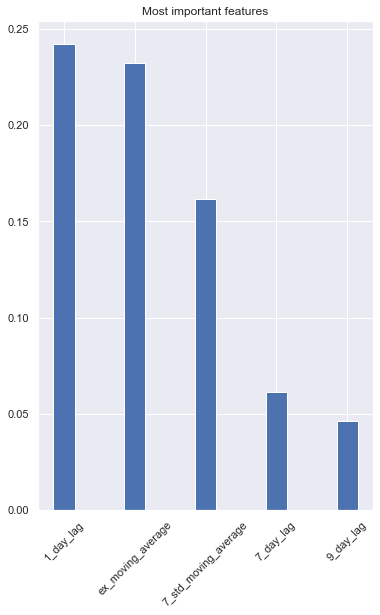

In [169]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
features_dic={}
for i,v in enumerate(importance):
    print('Feature ' + features_names[i] + ' , Score: %.5f' % (v))
    features_dic[features_names[i]]= v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(features_dic)
five_keys = sorted(features_dic, key=features_dic.get, reverse=True)[:5]
print(five_keys)
most_used = {key: features_dic[key] for key in five_keys}
plt.figure(figsize=(6,9))
plt.bar(most_used.keys(), most_used.values(), width=0.3)
plt.xticks(rotation=45)
plt.title('Most important features')
plt.savefig('Plots/1cycle.png', bbox_inches='tight')

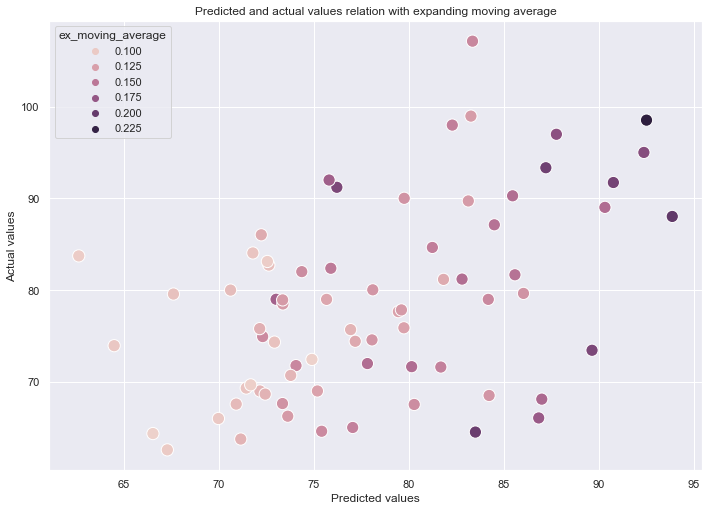

In [170]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/1st_stst_random_scatter.png', bbox_inches='tight')

The differentiated model behaves a lo better than the non-stationaty one. In fact, it seems to beat the rolling forward model. Is this true? Did I do something wrong? We'll see.

## Random Forest with PCA Stationary Time Series

Original shape: (360, 23)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.567
Accuracy on test set: -7.898
R2 is -7.897555538363813
The mean absolute error is 28.153120977419533
The root mean squared error is 916.5643196488179
The mean absolute percentage error is 34.98348729695666


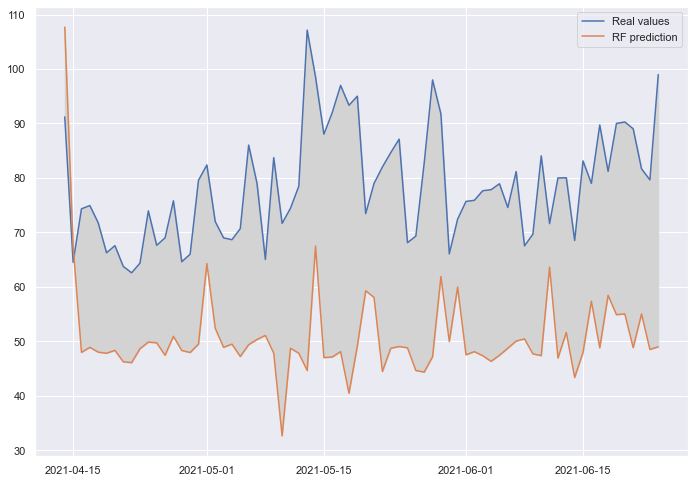

In [171]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = diff_data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = diff_data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=12, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test,y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.legend()
plt.savefig('Plots/1rf_nopce_plot.png', bbox_inches='tight')
plt.legend()

## Lasso model Stationary Time Series

In [175]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

Accuracy on training set: 0.476
Accuracy on test set: -0.171
R2 is -0.16114024133579496
The mean absolute error is 8.795045414858256
The root mean squared error is 119.61259592345469
The mean absolute percentage error is 11.284608627581722


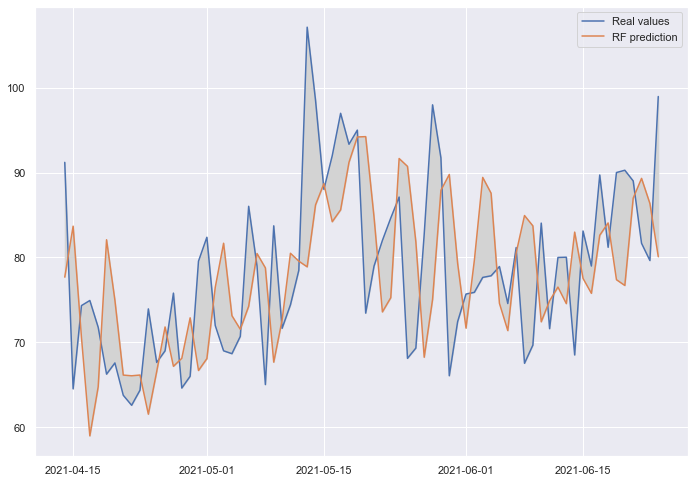

In [182]:
# Create the lasso model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, max_iter=8000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/1lasso_stst_plot.png', bbox_inches='tight')
plt.show()

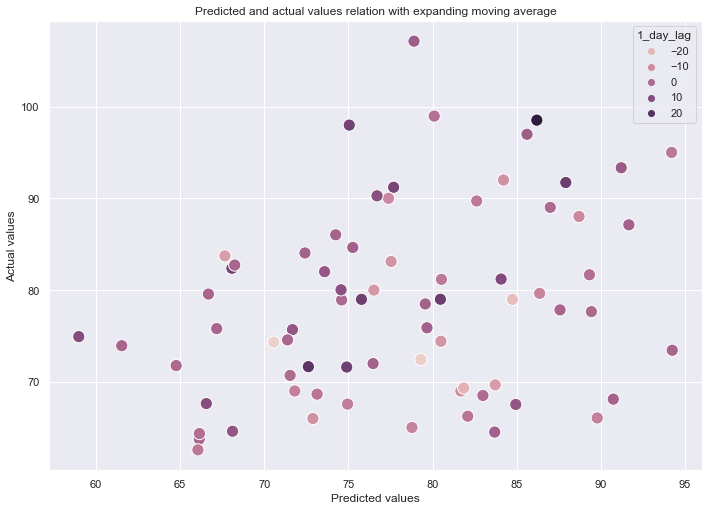

In [184]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='1_day_lag', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/1st_stst_lasso_scatter.png', bbox_inches='tight')

## Elastic Model Stationary Time Series

/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3325.2372843982375, tolerance: 6.853906226527777
  model = cd_fast.enet_coordinate_descent(


Accuracy on training set: 0.476
Accuracy on test set: -0.172
R2 is -0.16171585147583412
The mean absolute error is 8.79399440939253
The root mean squared error is 119.67189127869167
The mean absolute percentage error is 11.293055178925528


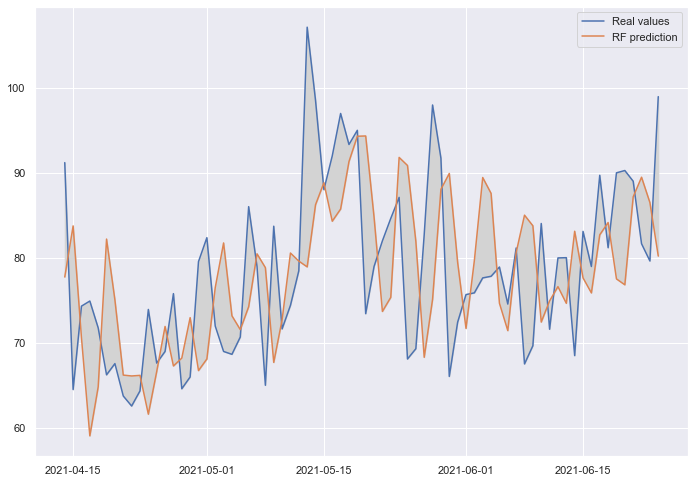

In [185]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.0001, l1_ratio=0.8, max_iter=8000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/1elastic_stst_plot.png', bbox_inches='tight')
plt.show()

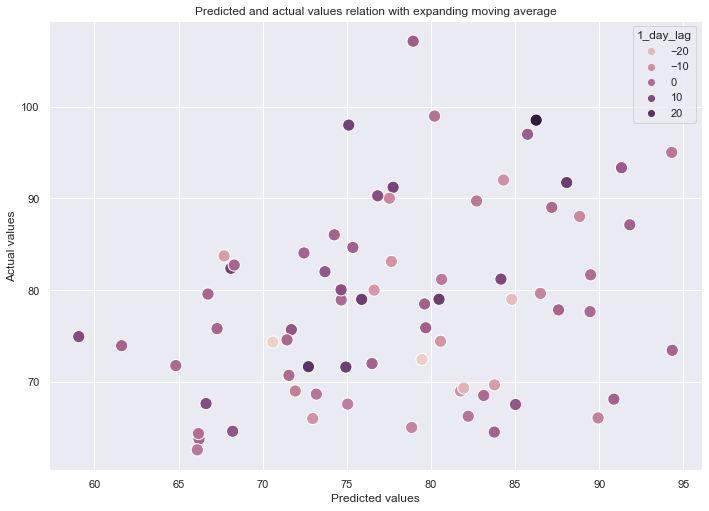

In [187]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='1_day_lag', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/1st_stst_elastic_scatter.png', bbox_inches='tight')

The most used features are the expanding moving average, the two day moving average and the one day lag feature

## Try combinations of different features with lag

weekday
Accuracy on training set: 0.029
Accuracy on test set: -6.989
R2 is -6.989348909648545
The mean absolute error is 26.64578383868313
The root mean squared error is 823.0071862137133
The mean absolute percentage error is 32.86588516306928


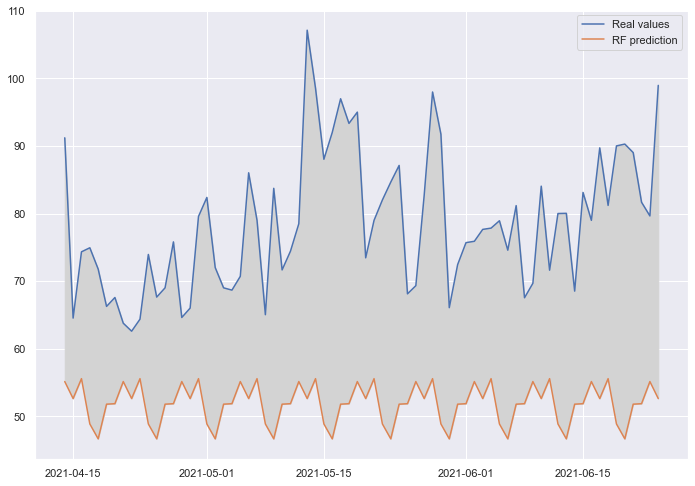

month
Accuracy on training set: 0.495
Accuracy on test set: -8.618
R2 is -8.617803991762049
The mean absolute error is 25.82929494234433
The root mean squared error is 990.759308465765
The mean absolute percentage error is 31.45855533900826


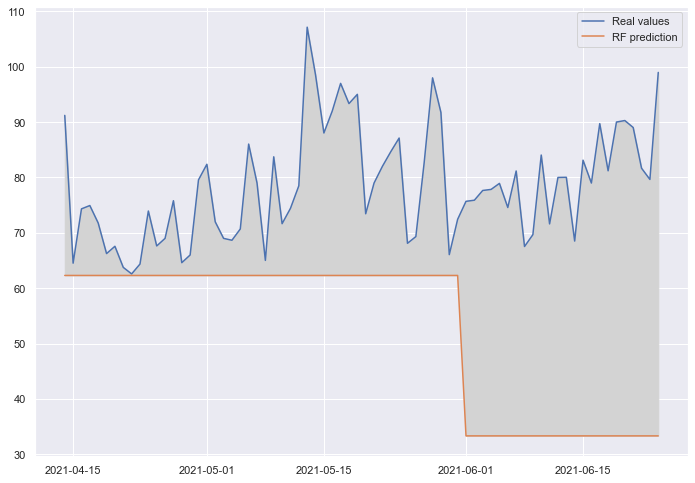

year
Accuracy on training set: 0.277
Accuracy on test set: -2.071
R2 is -2.071407760634578
The mean absolute error is 14.64641551236081
The root mean squared error is 316.39507641756325
The mean absolute percentage error is 17.358527829617916


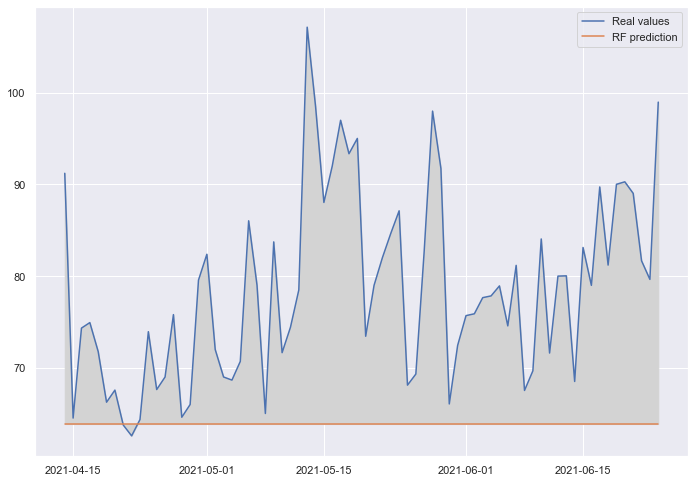

weekday_or_weekend
Accuracy on training set: 0.022
Accuracy on test set: -6.986
R2 is -6.986093751993989
The mean absolute error is 26.64920578299477
The root mean squared error is 822.671862500573
The mean absolute percentage error is 32.85413655972758


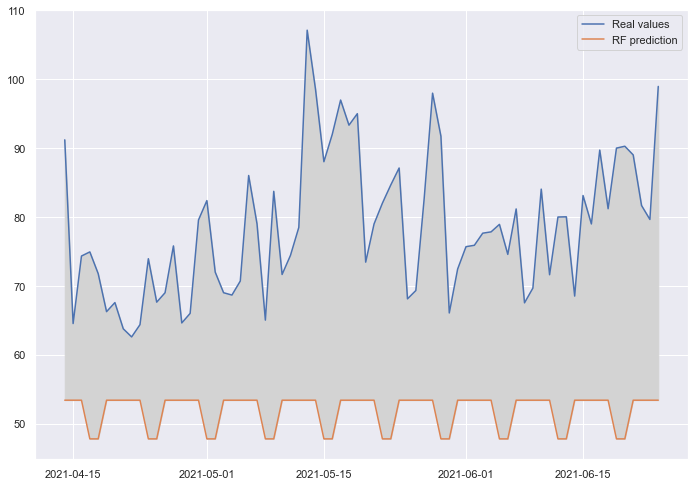

day_month
Accuracy on training set: 0.067
Accuracy on test set: -7.052
R2 is -7.052334250895072
The mean absolute error is 26.690060260298782
The root mean squared error is 829.4954982223943
The mean absolute percentage error is 32.99053870677785


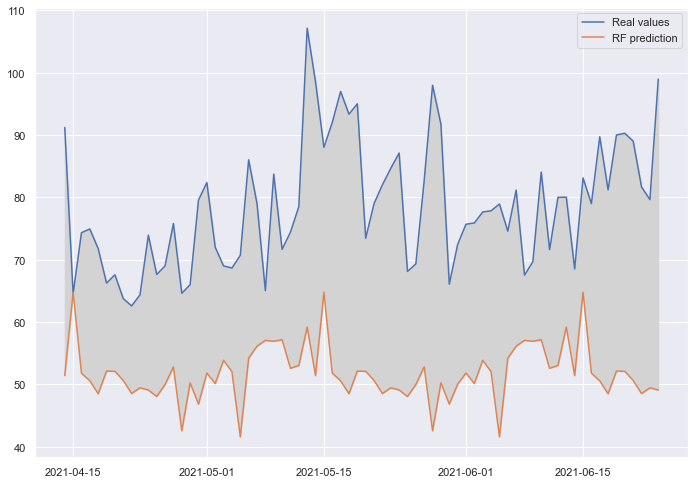

1_day_lag
Accuracy on training set: 0.503
Accuracy on test set: -7.553
R2 is -7.55281476176952
The mean absolute error is 27.700999179707637
The root mean squared error is 881.0515213311287
The mean absolute percentage error is 34.32777814659147


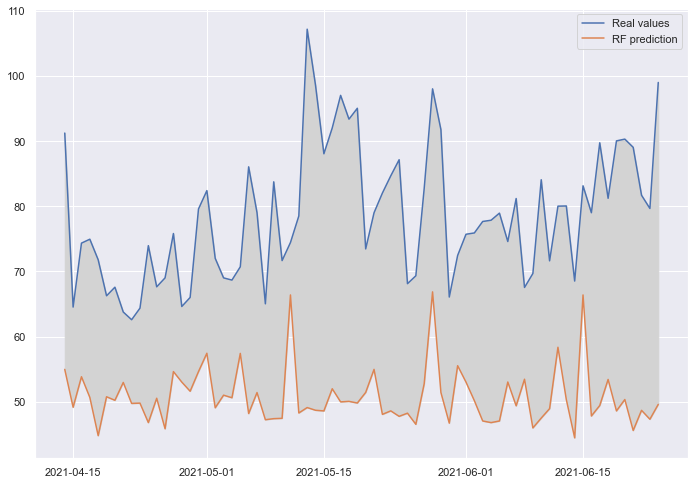

2_day_lag
Accuracy on training set: 0.502
Accuracy on test set: -7.797
R2 is -7.797164915931829
The mean absolute error is 28.09497087412706
The root mean squared error is 906.2227755975613
The mean absolute percentage error is 34.74532939563838


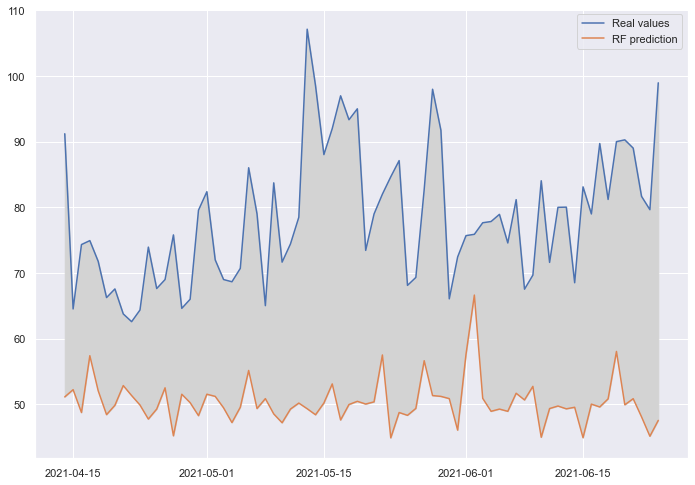

5_day_lag
Accuracy on training set: 0.589
Accuracy on test set: -7.717
R2 is -7.717083652119015
The mean absolute error is 27.47503382608363
The root mean squared error is 897.9733604894757
The mean absolute percentage error is 33.93157394851754


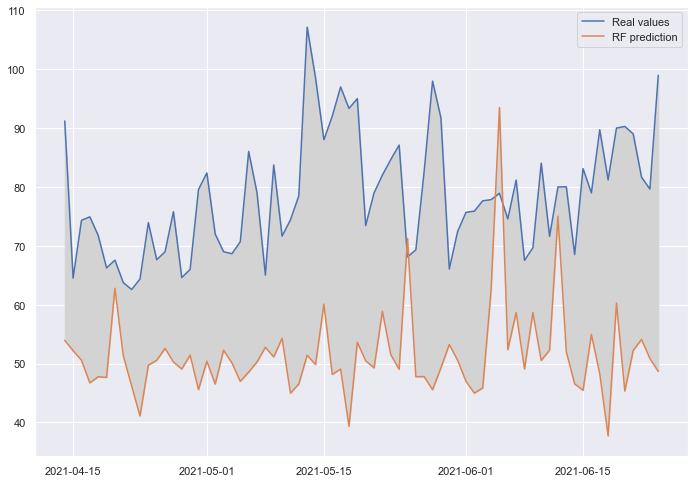

7_day_lag
Accuracy on training set: 0.513
Accuracy on test set: -7.424
R2 is -7.424211978073886
The mean absolute error is 27.29962811558964
The root mean squared error is 867.803756545093
The mean absolute percentage error is 33.76834633839333


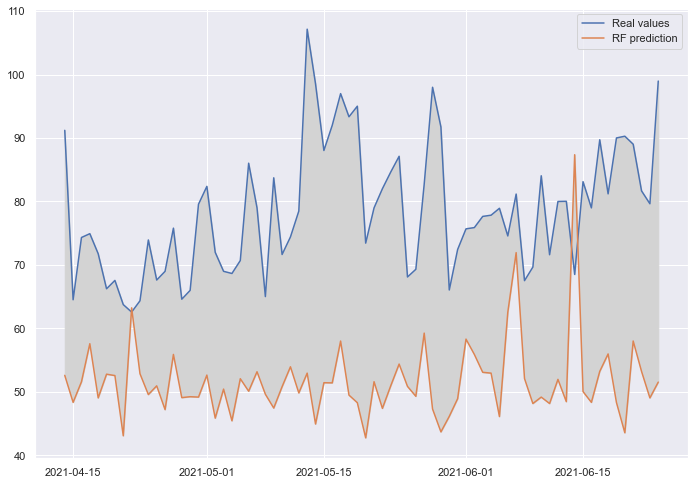

7_std_moving_average
Accuracy on training set: 0.549
Accuracy on test set: -6.097
R2 is -6.096814086501576
The mean absolute error is 24.851731842670826
The root mean squared error is 731.0644532447192
The mean absolute percentage error is 30.89009912154153


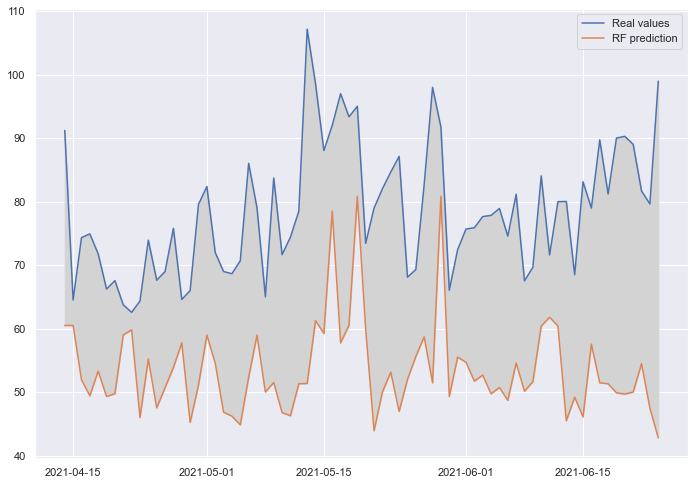

ex_moving_average
Accuracy on training set: 0.618
Accuracy on test set: -5.334
R2 is -5.3335762724138895
The mean absolute error is 23.01126710521481
The root mean squared error is 652.4409993327728
The mean absolute percentage error is 28.305335515773


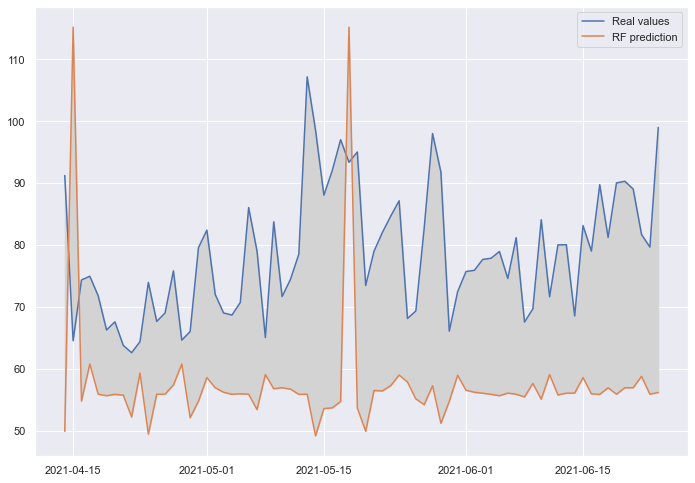

In [97]:
# Try individual of different features with lag
for i in ['weekday', 'month', 'year', 'weekday_or_weekend', 'day_month', '1_day_lag',
       '2_day_lag', '5_day_lag', '7_day_lag',
       '7_std_moving_average', 'ex_moving_average']:
    print(i)
    X_train = data_train[[i]].values
    y_train = data_train.value.values
    X_test = data_test[[i]].values
    y_test = data_test.value.values
    
    forest = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
    forest.fit(X_train, y_train)
    y_hat = forest.predict(X_test)
    
    print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
    print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
    # Scores:
    # R^2
    print('R2 is {}'
          .format(metrics.r2_score(y_test,y_hat)))
    # MAE
    print('The mean absolute error is {}'
          .format(metrics.mean_absolute_error(y_test,y_hat)))
    # RMSE
    print('The root mean squared error is {}'
          .format(metrics.mean_squared_error(y_test,y_hat)))
    #MAPE
    print('The mean absolute percentage error is {}'
          .format(mean_absolute_percentage_error(y_test,y_hat)))
    
    plt.plot(data_test.index, y_test, label='Real values')
    plt.plot(data_test.index, y_hat, label='RF prediction')
    plt.legend()
    plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
    plt.show()

We can see how the seven day moving average is informative about the peaks